# Looking for articles from EMBRAPA and public state universities in SP (SciELO Network)

As seen in a previous notebook, there are $3$ public universities
that are managed by the São Paulo state government:

* USP, *Universidade de São Paulo*
* UNICAMP, *Universidade Estadual de Campinas*
* UNESP, *Universidade Estadual Paulista*

The goal here is to find all research articles
in all collections in the SciELO network
coming from any of these $3$ universities
or from [EMBRAPA](https://www.embrapa.br/en/international).
Though this problem had been addressed in a previous notebook,
we're now including EMBRAPA and the dataset isn't the same.
Using the whole network instead of the SciELO Brazil collection
brings new challenges regarding:

* The *USP* acronym appears elsewhere (homonyms);
* *Saint Paul* (translation of *São Paulo*)
  is part of the name of [another university](https://ustpaul.ca/),
  in Canada;
* There are way more alternative writings;
* Several institution names are written in languages other than
  Portuguese, English and Spanish.

This notebook might have some parts that are similar to the last approach,
but the name-only evaluation doesn't suffice for this new dataset.

In [1]:
from functools import partial
import re

In [2]:
import pandas as pd
import regex
from unidecode import unidecode

In [3]:
%matplotlib inline

## Part 1: Loading the data

The information about each author institution
should be in the `documents_authors.csv` reports,
but if there's no link between the authors and the given affiliations,
it should still be in the `documents_affiliations.csv` file.
Let's open these
using the field name normalization step
that can be found in <https://github.com/scieloorg/scielo20gt6/>:

In [4]:
def normalize_column_title(name):
    name_unbracketed = re.sub(r".*\((.*)\)", r"\1",
                              name.replace("(in months)", "in_months"))
    words = re.sub("[^a-z0-9+_ ]", "", name_unbracketed.lower()).split()
    ignored_words = ("at", "the", "of", "and", "google", "scholar", "+")
    replacements = {
        "document": "doc",
        "documents": "docs",
        "frequency": "freq",
        "language": "lang",
        "instituition": "institution",
    }
    return "_".join(replacements.get(word, word)
                    for word in words if word not in ignored_words) \
              .replace("title_is", "is")

We'll use the same snapshot data from the previous experiments,
but including all data in the SciELO network,
not just SciELO Brazil.

In [5]:
reports_version = "2018-12-10" # Directory name

In [6]:
doc_affs = pd.read_csv(reports_version + "/documents_affiliations.csv") \
             .rename(columns=normalize_column_title)
doc_authors = pd.read_csv(reports_version + "/documents_authors.csv") \
                .rename(columns=normalize_column_title)

Let's join these to get a smaller dataset,
removing duplications
and entries without an explicit institution.

In [7]:
def renormalize_column_title(name):
    return name.replace("_scielo", "").split("_")[-1]

In [8]:
dataset = pd.concat([
    doc_affs[[
        "collection",
        "pid_scielo",
        "doc_affiliation_institution",
        "doc_affiliation_country",
        "doc_affiliation_state",
        "doc_affiliation_city",
    ]].rename(columns=renormalize_column_title),
    doc_authors[[
        "collection",
        "pid_scielo",
        "doc_author_institution",
        "doc_author_affiliation_country",
        "doc_author_affiliation_state",
        "doc_author_affiliation_city",
    ]].rename(columns=renormalize_column_title),
], sort=False).dropna(subset=["institution"]).drop_duplicates()
print(dataset.shape)
dataset.head()

(1367987, 6)


,collection,pid,institution,country,state,city
0,scl,S0100-879X1998000800006,University of Gorakhpur,NaN,NaN,NaN
1,scl,S0100-879X1998000800011,Universidade Estadual de Londrina,NaN,NaN,NaN
2,scl,S0100-879X1998000800005,Southern Sea Biology Institute,NaN,NaN,NaN
3,scl,S0100-879X1998000800005,Carleton University,NaN,NaN,NaN
4,scl,S0100-879X1998000800005,Ivano-Frankivsk State Medical Academy,NaN,NaN,NaN


How many *non-empty* entries are there in each field?

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1367987 entries, 0 to 1738918
Data columns (total 6 columns):
collection     1367987 non-null object
pid            1367987 non-null object
institution    1367987 non-null object
country        1134869 non-null object
state          604598 non-null object
city           888309 non-null object
dtypes: object(6)
memory usage: 73.1+ MB


How many *distinct* values are there in each field?

In [10]:
dataset.apply(lambda x: len(x.unique()))

collection         20
pid            732991
institution    168568
country          1542
state            4231
city            19783
dtype: int64

Some names are filled with "garbage/placeholder content"
and other way too small names
that shouldn't be seen as USP/UNESP/Unicamp/EMBRAPA
due to the lack of information.

In [11]:
raw_institution_names = dataset["institution"].drop_duplicates()
small_institution_names = \
    raw_institution_names[raw_institution_names.str.replace("\W", "")
                                               .str.len() <= 2].unique()
small_institution_names.sort()
small_institution_names

array(['*', '-', '.', '15', '3M', 'AC', 'BA', 'Bt', 'CA', 'CE', 'CI',
       'CP', 'DS', 'DZ', 'EE', 'ES', 'EU', 'F M', 'FC', 'FM', 'FO', 'FS',
       'GV', 'H. C.', 'H.C.', 'HC', 'HI', 'HP', 'HR', 'I', 'I & D', 'I-A',
       'IA', 'IB', 'IC', 'IF', 'IG', 'IP', 'IT', 'IZ', 'JB', 'JK', 'K.U',
       'K.U.', 'KU', 'LM', 'M.D.', 'M.S', 'MA', 'MC', 'MD', 'ME', 'MF',
       'MG', 'ML', 'MP', 'MS', 'MT', 'MZ', 'O & S', 'O&S', 'PA', 'PE',
       'PR', 'PT', 'QN', 'R & D', 'RJ', 'RN', 'RN.', 'RS', 'RT', 'S.L.',
       'S.S.', 'SC', 'SN', 'SP', 'SU', 'T.U', 'TM', 'U.A', 'U.A.', 'U.C',
       'U.C.', 'U.F.', 'U.H', 'U.J.', 'UA', 'UB', 'UC', 'UD', 'UE', 'UF',
       'UG', 'UH', 'UL', 'UM', 'UN', 'UP', 'UR', 'US', 'UT', 'UU', 'UV',
       'UZ', 'V', 'VO', 'VS', 'VU', 'WP', 'a', 'aa', 'bu', 'e', 'nd',
       's.a', 'v', 'xx'], dtype=object)

## Part 2: Country normalization

*Almost* all entries that matters are from Brazil.
That said, most affiliations that are obviously not from Brazil
can be discarded, and we should just replace the `country` field
by two fields:
a `is_brazil` and
a `mb_brazil` (standing for "might be Brazil");
both with either `True` or `False`.
Unknown entries should be marked as "might be Brazil".
However:

In [12]:
dataset["country"].dropna().drop_duplicates()

756                               Brazil
3222                              Brasil
3227                            Alemanha
3244                                 USA
3394                              France
3408                                  UK
3409                              Turkey
3415                           Indonesia
3416                           Australia
3424                             Belgium
3426                            Portugal
3429                                 U.K
3431                            Scotland
3432                             England
3433                               Kenya
3434                        Burkina Faso
3437                             Austria
3444                                Togo
3445                      United Kingdom
3447                               Italy
3450                           Venezuela
3461                               India
3478                           Argentina
3498                              Israel
3512            

Some entries have an e-mail instead of the country:

In [13]:
email_as_country_df = dataset[dataset["country"].fillna("").str.contains("@")]
email_as_country_df

,collection,pid,institution,country,state,city
203191,scl,S0101-31572008000200004,University of Lagos,muyiwaking@yahoo.com,Lagos,Akoka
212359,scl,S1516-35982007001000013,UNESP,rareis@fcav.unesp.br,SP,Jaboticabal
282518,scl,S0006-87052009000300021,Universidade Federal de Mato Grosso,emilioaz@ufmt.br,MT,Cuiabá
347198,scl,S0006-87052010000500007,Centro de Pesquisa e Desenvolvimento de Solos ...,sidney@iac.sp.gov.br,SP,Campinas
733339,scl,S0101-31572017000200381,Instituto de Pesquisa Econômica Aplicada,marcos.cintra@ipea.gov.br,NaN,NaN
894811,bol,S1562-38232012000400012,Argentina,jsalvador@citedef.gob.ar,NaN,NaN
897188,bol,S1012-29662016000200009,UMSS,aleantezana22@hotmail.com,NaN,Cochabamba
956770,chl,S0717-95532006000100007,Universidad San Sebastián,mariaelenaneira@hotmail.com,NaN,Concepción
989186,chl,S0717-95532016000200008,UESB,faby_jq@hotmail.com,BA,Jequié
1008190,chl,S0718-58392009000500001,Universidad de Buenos Aires,afcirelli@fvet.uba.ar,NaN,Buenos Aires


We can get the final part after the dot,
as in most entries that's a country code:

In [14]:
email_as_country_df["country"].str.replace(".*@.*\.", "")

203191     com
212359      br
282518      br
347198      br
733339      br
894811      ar
897188     com
956770     com
989186     com
1008190     ar
1107981     es
1123269     co
1132014     co
1152738     co
1209263    com
1474020    com
1527449    com
1650447     br
1681807     nz
1682902     za
1715604     es
1716731     es
1738654     cl
Name: country, dtype: object

Then, we should apply a fuzzy regex to get which entries are from Brazil:

In [15]:
is_br_re_search = partial(
    regex.search,
    "^br$|^(bra[sz]il){e<=2}$|(bra[sz]il){e<=1}"
)
countries_df = pd.DataFrame(
    dataset
    [["country"]]
    .dropna()
    .drop_duplicates()
    .assign(
        country_pre=lambda df: df["country"].apply(unidecode)
                                            .str.lower()
                                            .str.replace("\W|.*@.*\.", ""),
    ).assign(
        is_br=lambda df: df["country_pre"].apply(is_br_re_search).astype(bool),
    )
)
brazil_names = countries_df[countries_df["is_br"]]["country"].values.tolist()

In [16]:
pd.DataFrame([brazil_names[0::3],
              brazil_names[1::3],
              brazil_names[2::3]]).fillna("").T

,0,1,2
0,Brazil,Brasil,Brazi1
1,BRAZIL,Brazi,Brasi
2,BRASIL,Br,Brasília
3,Brzail,Brésil,Bra sil
4,Barzil,Brazill,- Brasil
5,Brasil.,Brasi l,rareis@fcav.unesp.br
6,BR,Brasíl,Brasill
7,- BRASIL,- BR,-BR
8,emilioaz@ufmt.br,sidney@iac.sp.gov.br,"SP, Brazil"
9,Brazil.,Brazile,Brasile


Other names that contains `BR` as a substring aren't *Brazil*:

In [17]:
countries_df[countries_df["country_pre"].str.contains("br") &
             ~countries_df["is_br"]]["country"]

11520                                          Great Britain
180116                                          Grã-Bretanha
290163                                   British West Indies
293668                                            Rio Branco
375598                                  Syrian Arab Republic
421894                  Estado Libre Asociado de Puerto Rico
658240                                          Grã-bretanha
660211     United Kingdom of Great Britain and Northern I...
792721     United Kingdom of Great Britain na Northern Ir...
810638                                                Brunei
859423                                          Gran Bretaña
1218903                                    Brunei Darussalam
1248918                                              Ginebra
1391946                               Arab Republic of Egypt
1719635                                            Bruxelles
Name: country, dtype: object

The remaining names are either:

- Another country;
- A mistake (e.g. a Brazilian state);
- Just some noise (actually unfilled data).

In [18]:
country_counts = dataset["country"].fillna("").value_counts()
empty_countries = countries_df[countries_df["country_pre"].str.len() <= 1] \
                              ["country"].tolist() + [""]
country_counts[country_counts.index.isin(empty_countries)]

     233118
-         6
(         2
U         1
z         1
E         1
a         1
.         1
Name: country, dtype: int64

In [19]:
br_states_in_country = countries_df[countries_df["country_pre"] \
    .isin(["sp", "rj", "go", "df", "pb", "ce", "rr",
           "minasgerais", "saopaulo", "riodejaneiro", "espiritosanto",
           "goias", "matogrosso", "matogrossodosul", "distritofederal",
           "parana", "riograndedosul", "santacatarina",
           "riograndedonorte", "sergipe", "bahia", "pernambuco",
           "piaui", "paraiba", "ceara", "maranhao", "alagoas",
           "amazonas", "acre", "roraima", "rondonia",
           "amapa", "tocantins", "para",
    ])]["country"].tolist()
country_counts[country_counts.index.isin(br_states_in_country)]

s.p                    93
SP                     14
São Paulo               7
Bahia                   7
Ceará                   6
RJ                      5
Minas Gerais            5
Paraná                  4
Rio de Janeiro          4
PB                      3
CE                      3
Amazonas                3
Pernambuco              3
Distrito Federal        2
GO                      2
D. F                    1
Rio Grande do Norte     1
.sp                     1
Sergipe                 1
Piauí                   1
Pará                    1
DF                      1
Goiás                   1
Paraíba                 1
Name: country, dtype: int64

It's pretty hard to find these other names.
`SP`, `RJ`, `GO`, `DF`, `PB`, `CE` and `RR`
aren't ISO 3166-1 alpha-2 codes,
so they're probably just the Brazilian state names,
though they might be an acronym for a country name
in another language.

In [20]:
might_be_br = countries_df[countries_df["country_pre"] \
    .isin(["mg", # Madagascar or Minas Gerais?
           "es", # Spain or Espírito Santo?
           "mt", # Malta or Mato Grosso?
           "ms", # Montserrat or Mato Grosso do Sul?
           "pr", # Puerto Rico or Paraná?
           "rs", # Serbia or Rio Grande do Sul?
           "sc", # Seychelles or Santa Catarina?
           "rn", # Niger or Rio Grande do Norte?
           "se", # Sweden or Sergipe?
           "ba", # Bosnia and Herzegovina or Bahia?
           "pe", # Peru or Pernambuco?
           "pi", # Philippines or Piauí?
           "ma", # Morocco or Maranhão?
           "al", # Albania or Alagoas?
           "am", # Armenia or Amazonas?
           "ac", # Ascension Island or Acre?
           "ro", # Romania or Rondônia?
           "ap", # African Regional Industrial Property Organization or Amapá?
           "to", # Tonga or Tocantins?
           "pa", # Panama or Pará?
    ]) & (countries_df["country"].str.len() <= 5)]["country"].tolist()
country_counts[country_counts.index.isin(might_be_br)]

PR      11
RS      10
ES       7
MG       4
PE       4
BA       3
MA       2
PA       2
AL       2
P.R.     2
SC       1
MT       1
Name: country, dtype: int64

Can the country be in another field?

In [21]:
dataset[
    ~dataset["country"].isin(brazil_names) &
    ~dataset["country"].isna() &
    dataset["state"].isin(brazil_names)
]

,collection,pid,institution,country,state,city
732797,scl,S2237-101X2017000200381,Jardim Botânico do Rio de Janeiro,E,Brasil,Rio de Janeiro
831244,arg,S1850-15322009000300007,Universitäts Klinikum Freiburg,Germany,Br,Freiburg
1522434,rve,S0104-35522012000200018,Universidade Federal do Rio de Janeiro,E-mail,Brasil,Rio de Janeiro


Yes. So let's find Brazil in all text fields.

In [22]:
all_texts = (dataset
    .drop(columns=["collection", "pid"])
    .fillna("")
    .applymap(unidecode)
    .T.apply(lambda row: " ".join(row))
    .str.lower()
    .str.replace("\W", " ")
)

In [23]:
br_in_all_texts = all_texts.apply(is_br_re_search).apply(bool)

In [24]:
pd.DataFrame(
    dataset[
        ~dataset["country"].isin(brazil_names) &
        ~dataset["country"].isna() &
        br_in_all_texts
    ]
    .fillna("")
    .groupby(["country", "state", "city", "institution"])
    .size()
    .rename("count")
)

count
country          state                         city                   institution                                              
70610-200        DF                            Brasília               Polícia Civil do Distrito Federal                       1
Amazonas                                       Manaus                 Universidade Luterana do Brasil                         1
Argentina                                                             Clínica Basilea                                         2
                                               C.A.B.A                Clínica Basilea                                         2
                                               Ciudad de Buenos Aires Clínica Basilea                                         1
Buenos Aires     PI                            Teresina               Empresa Brasileira de Pesquisa Agropecuária             1
Canada                                         Toronto                University of Brasilia                                  1
Colombia                                       Bogotá                 Universidad de Brasília                                 1
                                               Brasília               Organização Pan-Americana da Saúde                      4
                 D.F.                          Brasilia               Organização Pan-Americana da Saúde                      1
                 DF                            Brasilia               Universidad Nacional de Colombia                        1
                                               Brasília               Organização Pan-Americana da Saúde                      2
                                                                      Organização Pan-americana da Saúde                      1
Cuba                                           Matanzas               Universidad de Brasilia                                 1
DF               Taguatinga                    Águas Claras           Universidade Católica de Brasília                       1
Distrito Federal                               Brasília               Ministério da Saúde                                     1
E                Brasil                        Rio de Janeiro         Jardim Botânico do Rio de Janeiro                       1
E-mail           Brasil                        Rio de Janeiro         Universidade Federal do Rio de Janeiro                  1
EUA                                                                   Universidade de Brasília                                1
                                               São Francisco          Cônsul Geral do Brasil                                  1
Espanha          Comunidade Autónoma de Madrid Madrid                 Fundação Cultural Hispano-Brasileira                    1
España                                         Murcia                 Residencia Pública de Personas Mayores San Basilio      1
France                                         Brasília               Institut de Recherche pour le Développement             1
                 DF                            Brasília               Institut de Recherche pour le Développement             1
Ireland                                        Brasília               European College of Management                          1
Italia                                         Potenza                Universita degli Studi della Basilicata                 1
Italy                                                                 University of Basilicata                                1
                                                                      Università degli Studi della Basilicata                 2
                                               Foggia                 Istituto Zooprofilattico Sperimentale della Pug...      1
                                                                      Istituto Zooprofilattico Sperimentale di Puglia...      1
...                       

Several of the above entries aren't from Brazil,
on the other hand it won't hurt
to say all these entries "might be Brazil",
since the number of entries is small.

## Part 3: State normalization

For USP/UNESP/Unicamp,
it would be useful to filter by the state name,
as it should be `São Paulo` for all of them,
but it's not a normalized field:

In [25]:
dataset["state"].dropna().drop_duplicates()

3222                                      RS
3224                                      PR
3226                                      SP
3236                                      MG
3396                                      PE
3397                                      RJ
3412                                      CE
3417                                      MS
3420                                      SC
3421                                      CA
3443                                      CO
3458                                   Texas
3461                                  Mumbai
3462                      State of São Paulo
3492                               São Paulo
3512                                    D.F.
3550                                   S. P.
3598                                      Pr
3600                                      DF
3602                                      DC
3604                                    S.C.
3606                                    S.P.
3607      

There's no e-mail filled in as the state name:

In [26]:
dataset[dataset["state"].fillna("").str.contains("@")].empty

True

In [27]:
is_sampa_re_search = partial(
    regex.search,
    "^s+p+$|(s(ao)?paulo|s(ain)?tpaul){e<=1}"
)
not_sampa_list = ["pablo", "palmas", "galo", "spain", "seoul"]
states_df = pd.DataFrame(
    dataset
    [["state"]]
    .dropna()
    .drop_duplicates()
    .assign(
        state_pre=lambda df: df["state"].apply(unidecode)
                                        .str.lower()
                                        .str.replace("\W", ""),
    ).assign(
        is_sp=lambda df: df["state_pre"].apply(
                             lambda name: all(ns not in name
                                              for ns in not_sampa_list)
                                          and bool(is_sampa_re_search(name))
                         ) | df["state"]
                             .str.lower()
                             .str.replace("\W", " ")
                             .apply(lambda name: "sp" in name.split()),
    )
)
sp_names = states_df[states_df["is_sp"]]["state"].tolist()

In [28]:
pd.DataFrame([sp_names[0::3],
              sp_names[1::3],
              sp_names[2::3]]).fillna("").T

,0,1,2
0,SP,State of São Paulo,São Paulo
1,S. P.,S.P.,Sao Paulo
2,SãoPaulo,S.P,"SP,"
3,S.Paulo,S. Paulo,São Paulo State
4,SP.,S P,Sao Paulo State
5,SP),- SP,S. P
6,SPP,-SP,S/P
7,"São Paulo,",São Paulo/SP,Campinas/SP
8,São Paulo|SP,"São Paulo, SP",SSP
9,Sp,sp,SÃ£o Paulo


The remaining names are probably not *São Paulo*.

In [29]:
states_df[states_df["state_pre"].str.contains("sp|sampa") & ~states_df["is_sp"]]["state"]

7700                                 Espírito Santo
31181                                       Espanha
107627                                       España
173221                                        Spain
204148                                Nueva Esparta
260417                               Espirito Santo
669499                              San Luis Potosí
735021                              San Luís Potosí
768580                              Sancti Spíritus
805434                        Buenos Aires Province
836983                               Espíritu Santo
887410                             Villa Carlos Paz
913024                         Estado Nueva Esparta
922003                      Núcleo de Nueva Esparta
956833                     Estado do Espírito Santo
970422                   Las Palmas de Gran Canaria
1028180                              Santi Spíritus
1048559                             Sancti Spiritus
1056351                              Sacti Spiritus
1061255     

Unfilled (including single-lettered) states:

In [30]:
state_counts = dataset["state"].fillna("").value_counts()
empty_states = states_df[states_df["state_pre"].str.len() <= 1] \
                        ["state"].tolist() + [""]
state_counts[state_counts.index.isin(empty_states)]

      763389
M          3
S          3
D          1
N          1
(          1
G          1
D.         1
i          1
-          1
,          1
Name: state, dtype: int64

Collecting the name of the cities with at least one campus
belonging to one of the chosen universities:

In [31]:
sp_cities_in_state = states_df[states_df["state_pre"] \
    .isin(["bauru", "ribeiraopreto", "saocarlos", "franca",
           "piracicaba", "pirassununga", "lorena", "santos",
           "campinas", "limeira", "paulinia", "saojoaodaboavista",
           "saojosedoriopreto", "saojose", "saojosedoscampos",
           "dracena", "botucatu", "rioclaro", "araraquara",
           "ourinhos", "assis", "itapeva", "registro",
           "saovicente", "guaratingueta", "sorocaba",
           "jaboticabal", "marilia", "tupa", "presidenteprudente",
           "aracatuba", "ilhasolteira", "rosana",
    ]) & (states_df["state"] != "França")]["state"].tolist()
country_counts[country_counts.index.isin(sp_cities_in_state)]

Bauru    1
Name: country, dtype: int64

Is there any other field filled with "São Paulo"?

In [32]:
sp_in_all_texts = all_texts.apply(is_sampa_re_search).apply(bool)

In [33]:
pd.DataFrame(
    dataset[
        ~dataset["state"].isin(sp_names) &
        ~dataset["state"].isna() &
        sp_in_all_texts
    ]
    .fillna("")
    .groupby(["country", "state", "city", "institution"])
    .size()
    .rename("count")
)

count
country                   state                 city                     institution                                              
                          14040-902                                      Universidade de São Paulo                               1
                          37950-000                                      Universidade de São Paulo                               1
                          BA                    Paulo Afonso             Companhia Hidro Elétrica do São Francisco               1
                                                                         Universidade do Estado da Bahia                         1
                          Brasil                Sao Paulo                Universidad Cruceiro do Sol Sao Paulo Brasil            1
                                                São Paulo                CNEM                                                    1
                                                                         FMB/UNESP                                               1
                                                                         Instituto Israelita de Ensino e Pesquisa Albert...      1
                                                                         SciELO                                                  2
                                                                         Secretaria de Estado da Saúde de São Paulo              1
                                                                         USP                                                     3
                                                                         Unicamp                                                 1
                                                                         Universidade de Santo Amaro                             1
                                                                         Universidade de São Paulo                               3
                                                                         Universidade de Taubaté                                 1
                          Brazil                Sao Paulo                Syrian-Lebanese Hospital                                1
                                                São José dos Campos      São Paulo State University                              1
                                                São Paulo                Universidade Federal de São Paulo                       1
                          CE                    Aquiraz                  Universidade de São Paulo                               1
                                                Foprtaleza               Universidade de São Paulo                               1
                                                Fortaleza                Universidade de São Paulo                               2
                          GO                    Itumbiara                Comunidade Evangélica ‘São Paulo’                       1
                          MG                    Acaiaca                  EFA Paulo Freire                                        1
                                                Belo Horizonte           Universidade de São Paulo                               1
                                                Divinópolis              Universidade de São Paulo                               1
                                                São Sebastião do Paraíso Universidade de São Paulo                               1
                          RJ                                             Pontifícia Universidade Católica de São Paulo           1
                                                Rio de Janeiro           Hospital São Vicente de Paulo                           1
                                                                         Universidade Federal de São Paulo                       1
                          RS                                    

Again, several entries have nothing to do with the Brazilian state,
but we'll still say all these entries "might be São Paulo".

## Part 4: Iterative "collateral effect" manual classification

As it'll be way too hard to find a single criterion
that will match every single entry in this dataset,
we'll use both a *subtractive* and an *additive* approach
to include and remove entries,
updating a dataset of "remaining" PIDs.

In [34]:
solution = pd.DataFrame({
    "usp": None,
    "unesp": None,
    "unicamp": None,
    "embrapa": None,
}, index=dataset.index, dtype=float).assign(pid=dataset["pid"])

Where the values in this table are:

- `0.0`: False;
- `1.0`: True;
- `NaN` (Not a Number): Unknown.

The lack of information means
these entries aren't from any of these desired outputs.

In [35]:
solution.loc[
    dataset[dataset["institution"].isin(small_institution_names)].index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.

How many PIDs do we have in total?

In [36]:
solution["pid"].drop_duplicates().size

732991

A way to get some statistics for the solution
during this iterative approach:

In [37]:
def solution2pids(df):
    has_unfilled = df.fillna(0).groupby("pid").count() \
                 - df.groupby("pid").count() \
                 > 0
    is_true = df.groupby("pid").any()
    is_nan = has_unfilled & ~is_true
    all_pids = (is_nan * 2 + is_true).replace({
        0: "false",
        1: "true",
        2: "unknown"
    })
    all_pids.columns.name = "institute"
    return all_pids

In [38]:
def pids2stats(df):
    return pd.DataFrame(df
        .unstack()
        .rename("target")
        .reset_index()
        .groupby(["institute", "target"])
        .size()
        .rename("count")
        .unstack()
        .fillna(0)
        .astype(int)
    )

In [39]:
pids2stats(solution2pids(solution))

target,false,unknown
institute,,
embrapa,67,732924
unesp,67,732924
unicamp,67,732924
usp,67,732924


A simple explanation of these statistics:

- The target is `false` when ALL rows for that PID
  aren't from the given institution;
- The target is `true` when ANY row for that PID
  is from the given institution;
- Otherwise the target is `unknown`.

Our goal is to decrease the `unknown` to zero,
so `solution2pids(solution)` will be our desired solution
based on PIDs.

### Wordlist acronym approach

Let's add some fields regarding the previous steps
and a wordlist for the institution name.
This is the first try for a classification:
if the acronym is in the list,
we already know the correct classification
(though there might be some false positive,
 e.g. `USP` names from other countries).

In [40]:
wl_dataset = dataset.assign(
    is_br=dataset["country"].isin(brazil_names + br_states_in_country),
    is_sp=dataset["state"].isin(sp_names + sp_cities_in_state),
    word_list=dataset["institution"].fillna("")
                                    .apply(unidecode)
                                    .str.replace("\W", " ")
                                    .str.lower()
                                    .str.split(),
).assign(
    mb_br=lambda df: df["is_br"]
                   | df["country"].isna()
                   | df["country"].isin(empty_countries + might_be_br)
                   | br_in_all_texts,
    mb_sp=lambda df: df["is_sp"]
                   | df["state"].isna()
                   | df["state"].isin(empty_states)
                   | sp_in_all_texts,
    ipre=lambda df: df["word_list"].str.join(" "),
    has_usp=lambda df: df["word_list"].apply(lambda wl: "usp" in wl),
    has_unesp=lambda df: df["word_list"].apply(lambda wl: "unesp" in wl),
    has_unicamp=lambda df: df["word_list"].apply(lambda wl: "unicamp" in wl),
    has_embrapa=lambda df: df["word_list"].apply(lambda wl: "embrapa" in wl),
)
wl_dataset[1000:5000:1200].T

,1495,3006,4415,5795
collection,scl,scl,scl,scl
pid,S0103-90161998000100010,S0103-90161996000100024,S0100-879X1999000700006,S0074-02761999000600004
institution,USP,ESALQ,Universidade de São Paulo,Universidade Federal de Minas Gerais
country,NaN,NaN,Brasil,Brasil
state,NaN,NaN,SP,MG
city,NaN,NaN,Ribeirão Preto,Belo Horizonte
is_br,False,False,True,True
is_sp,False,False,True,False
word_list,[usp],[esalq],"[universidade, de, sao, paulo]","[universidade, federal, de, minas, gerais]"
mb_br,True,True,True,True


The number of `True` entries in each field
(`mb` stands for "might be",
 and all entries that "are something" also "might be something"):

In [41]:
wl_dataset[["is_br", "mb_br", "is_sp", "mb_sp",
            "has_usp", "has_unicamp", "has_unesp", "has_embrapa"]].sum()

is_br          580292
mb_br          813586
is_sp          156830
mb_sp          920649
has_usp          4554
has_unicamp      1287
has_unesp        1635
has_embrapa     14266
dtype: int64

Are there inconsistent entries?

In [42]:
wl_multi_valued = wl_dataset[
    wl_dataset[["has_usp", "has_unicamp",
                "has_unesp", "has_embrapa"]].T.sum() > 1
]
wl_multi_valued.T

,1144697
collection,col
pid,S1794-47242015000200002
institution,Universidade de São Paulo (USP)/Universidade E...
country,Brasil
state,NaN
city,NaN
is_br,True
is_sp,False
word_list,"[universidade, de, sao, paulo, usp, universida..."
mb_br,True


That's actually a multi-valued non-ambiguous entry,
not an inconsistency:

In [43]:
wl_multi_valued["institution"].tolist()

['Universidade de São Paulo (USP)/Universidade Estadual Paulista (UNESP)']

In [44]:
solution.loc[
    wl_multi_valued.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = 1. * wl_multi_valued[["has_usp", "has_unesp",
                          "has_unicamp", "has_embrapa"]].values

In [45]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,68,0,732923
unesp,67,1,732923
unicamp,68,0,732923
usp,67,1,732923


We should look for inconsistencies regarding the country and the state.

#### EMBRAPA acronym consistency

In [46]:
ac_cols2remove = ["word_list", "ipre",
                  "has_usp", "has_unesp", "has_unicamp", "has_embrapa"]

In [47]:
wl_dataset[
    ~wl_dataset["is_br"] &
    ~wl_dataset["country"].isna() &
    wl_dataset["has_embrapa"]
].drop(columns=ac_cols2remove)

,collection,pid,institution,country,state,city,is_br,is_sp,mb_br,mb_sp
39855,scl,S1519-566X2002000400001,Embrapa-Labex-USA,USA,NaN,NaN,False,False,False,True
54349,scl,S0100-41582003000500001,Embrapa,France,NaN,NaN,False,False,False,True
60767,scl,S0100-67622003000500017,Embrapa Labex,USA,Maryland,Beltsville,False,False,False,False
293668,scl,S1413-70542009000700003,Embrapa Acre,Rio Branco,AC,Zona Rural,False,False,False,False
402502,scl,S0101-20612011000400012,Embrapa Labex Europa,France,NaN,NaN,False,False,False,True
530884,scl,S0044-59672014000400011,Embrapa Labex Europa,France,NaN,Montpellier,False,False,False,True
543687,scl,S1983-40632010000400006,Embrapa Labex Europa,France,NaN,Montpellier,False,False,False,True
584465,scl,S0100-06832015000200377,Embrapa,France,NaN,Montpellier,False,False,False,True
606243,scl,S1984-29612015000300317,Embrapa Labex,United States,NaN,Beltsville,False,False,False,True
642176,scl,S0100-69162015000601172,Embrapa Labex USA,United States,NaN,NaN,False,False,False,True


Indeed, *EMBRAPA* exists in other countries,
in a program called [Labex](https://www.embrapa.br/programa-embrapa-labex).

However, all `Spain` entries are actually from Brazil.
In one such entry, `Brasil` appeared as the city instead of the country,
but the institution name
have both the EMBRAPA detailed name and its address,
and it's just the
[Embrapa Dairy Cattle](https://www.embrapa.br/en/gado-de-leite/dados-cadastrais)
(Brazil, MG).
`Embrapa Tropical Semiárido` happens to be
[Embrapa Semi-Arid](https://www.embrapa.br/en/semiarido/dados-cadastrais)
(Brazil, PE).

The `Rio Branco` country is actually a city name (Brazil, AC).
All other names actually belongs to EMBRAPA in other countries,
including
[Embrapa África](
  http://memoria.ebc.com.br/agenciabrasil/galeria/2008-04-20/20-de-abril-de-2008
).
These should be the only EMBRAPA entries from outside Brazil,
unless some other entry doesn't have the explicit acronym.

That said, every entry that has the EMBRAPA acronym
should be seen as belonging to it,
no matter the country.

In [48]:
solution.loc[
    wl_dataset["has_embrapa"],
    "embrapa"
] = 1.

In [49]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,68,12095,720828
unesp,67,1,732923
unicamp,68,0,732923
usp,67,1,732923


#### Unicamp/UNESP code/acronym consistency

All entries are or might be from Brazil.

In [50]:
wl_dataset[~wl_dataset["mb_br"] & wl_dataset["has_unicamp"]].empty

True

In [51]:
wl_dataset[~wl_dataset["mb_br"] & wl_dataset["has_unesp"]].empty

True

Which *Unicamp* entries aren't from São Paulo?

In [52]:
unicamp_notsp = wl_dataset[
    wl_dataset["mb_br"] &
    ~wl_dataset["is_sp"] &
    ~wl_dataset["state"].isna() &
    wl_dataset["has_unicamp"]
].drop(columns=ac_cols2remove)
unicamp_notsp.set_index("pid")

,collection,institution,country,state,city,is_br,is_sp,mb_br,mb_sp
pid,,,,,,,,,
S0104-59702003000200017,scl,Unicamp,Brasil,RJ,Rio de Janeiro,True,False,True,False
S0021-75572011000400014,scl,UNICAMP,NaN,SC,Florianópolis,False,False,True,False
S0103-73072011000300014,scl,Unicamp,NaN,FE,NaN,False,False,True,False
S1518-61482009000400006,psi,UNICAMP,NaN,Minas Gerais,Uberlândia,False,False,True,False
S0104-07072012000300015,rve,Unicamp,NaN,Brasil,São Paulo,False,False,True,True


The last row has just some shifted fields.
The other ones don't look right,
since `FE` isn't a Brazilian state,
and *Unicamp* has no campus at these other Brazilian states.
The author and publishing year related to these entries are:

In [53]:
unicamp_notsp_authors = doc_authors[
    (doc_authors["doc_author_affiliation_state"].isin([
        "RJ", "SC", "FE", "Minas Gerais",
    ])) &
    (doc_authors["doc_author_institution"].str.upper() == "UNICAMP")
][["pid_scielo", "doc_publishing_year", "doc_author"]].set_index("pid_scielo")
unicamp_notsp_authors

,doc_publishing_year,doc_author
pid_scielo,,
S0104-59702003000200017,2003,Alex Gonçalves Varela
S0021-75572011000400014,2011,Camila Isabel Santos Schivinski
S0103-73072011000300014,2011,Carlos Eduardo Albuquerque Miranda
S1518-61482009000400006,2009,João Luiz Leitão Paravidini


Their Lattes:

- [Alex Gonçalves Varela](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4795093J6
  ): Mastership at UNICAMP in 2003.
  His graduation and postdoc were in RJ, but not in that year;
- [Camila Isabel Santos Schivinski](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4133346E6
  ): Works for UDESC since 2009.
  It tells she's also a collaborator for Unicamp,
  but [the article itself](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0021-75572011000400014&lng=en&nrm=iso&tlng=en
  ) tells she's from UDESC, not Unicamp;
- [Carlos Eduardo Albuquerque Miranda](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4782899J4
  ): `FE` stands for
  [*Faculdade de Educação*](https://www.fe.unicamp.br/)
  (Pedagogy college),
  and [the article](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-73072011000300014&lng=en&nrm=iso&tlng=en
  ) clearly states the author is from Unicamp;
- [João Luiz Leitão Paravidini](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4772134H5
  ): works at Uberlândia since 1994,
  studied at Campinas until 2002,
  it seems that, formally, he had never went back there.

Camila and Carlos entries should haven't been assigned to Unicamp,
whereas the other two entries
have misleading data in the remaining fields.

Another approach to detect that would be
the number of publications by year in each institution for these authors:

In [54]:
pd.DataFrame(doc_authors
    [doc_authors["doc_author"].isin(unicamp_notsp_authors["doc_author"])]
    .groupby(["doc_author", "doc_publishing_year", "doc_author_institution"])
    .size()
    .rename("count")
)

count
doc_author                         doc_publishing_year doc_author_institution                             
Alex Gonçalves Varela              2002                Universidade Estadual de Campinas                 1
                                   2003                Unicamp                                           1
                                   2004                Universidade Estadual de Campinas                 1
                                   2005                Universidade Estadual de Campinas                 1
                                   2006                Universidade Estadual de Campinas                 1
                                   2007                Ministério da Ciência, Tecnologia e Inovação      2
                                                       Museu de Astronomia e Ciências Afins              2
                                   2008                Ministério da Ciência, Tecnologia e Inovação      1
                                   2010                Ministério da Ciência e Tecnologia                1
                                                       Museu de Astronomia e Ciências Afins              1
                                   2014                Museu de Astronomia e Ciências Afins              1
                                   2016                Universidade do Estado do Rio de Janeiro          1
Camila Isabel Santos Schivinski    2011                UNICAMP                                           1
                                                       Universidade do Estado de Santa Catarina          4
                                   2012                Universidade do Estado de Santa Catarina          1
                                   2013                Universidade do Estado de Santa Catarina          6
                                   2014                Universidade do Estado de Santa Catarina          1
                                   2016                UDESC                                             1
                                   2017                State University of Santa Catarina                1
                                                       Universidade do Estado de Santa Catarina          2
                                   2018                Universidade Estadual de Campinas                 1
                                                       Universidade do Estado de Santa Catarina          3
Carlos Eduardo Albuquerque Miranda 2011                Unicamp                                           1
João Luiz Leitão Paravidini        2007                Universidade Federal de Uberlândia                1
                                   2008                Universidade Federal de Uberlândia                2
                                   2009                UNICAMP                                           1
                                                       Universidade Federal de Uberlândia                3
                                   2010                Universidade Federal de Uberlândia                2
                                   2011                Universidade Federal de Uberlândia                3
                                   2012                UFU                                               1
                                                       Universidade Federal de Uberlância                1
                                                       Universidade Federal de Uberlândia                1
                                   2013                Universidade Federal de Uberlândia                2
                                                       Universidade Federal de Uberlândia (UFU)          1
                                   2014                Universidade Federal de Uberlândia                1
                                                       Universidade federal de Uberlândia                1
                                   

In [55]:
solution.loc[
    unicamp_notsp.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = unicamp_notsp.assign(
    usp=0.,
    unesp=0.,
    unicamp=1. * ~unicamp_notsp["state"].isin(["SC", "Minas Gerais"]),
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [56]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,70,12095,720826
unesp,69,1,732921
unicamp,68,3,732920
usp,69,1,732921


Which *UNESP* entries aren't from São Paulo?

In [57]:
unesp_notsp = wl_dataset[
    wl_dataset["mb_br"] &
    ~wl_dataset["is_sp"] &
    ~wl_dataset["state"].isna() &
    wl_dataset["has_unesp"]
].drop(columns=ac_cols2remove)
unesp_notsp.set_index("pid")

,collection,institution,country,state,city,is_br,is_sp,mb_br,mb_sp
pid,,,,,,,,,
S1519-69842006000100013,scl,Light SESA/UNESP,Brazil,RJ,Piraí,True,False,True,False
S0104-80232005000100010,scl,UNESP/Araraquara,NaN,Pr,Maringá,False,False,True,False
S0006-87052008000300001,scl,UNESP,Brasil,PE,Petrolina,True,False,True,False
S0365-66912006001200002,esp,Universidad del Estado de San Pablo (UNESP),Brasil,San Pablo,Araraquara,True,False,True,False
S0104-07072009000100012,rve,FMB/UNESP,NaN,Brasil,São Paulo,False,False,True,True
S0378-18442003000200007,ven,Universidade Estadual de São Paulo (UNESP),Brasil,PR,Maringá,True,False,True,True


Some remarks:

- The [S1519-69842006000100013](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1519-69842006000100013&lng=en&nrm=iso&tlng=en
  ) entry looks misleading, as not even the author name is clear.
  The actual author is [Rinaldo Jose da Silva Rocha](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4782602U5
  ), and the Light tells us that [UNESP had some participation](
    http://www.light.com.br/repositorio/ped%20balancos/balanco2009.htm
  ) with some research and development project,
  but the years don't seem to match.
  Nevertheless, UNESP seem to have something to do with this entry;
- `Araraquara` is the name of a city in the State of *São Paulo*
  where lies a UNESP campus;
- [FMB/UNESP](http://fmb.unesp.br/) is at Botucatu (*São Paulo*);
- The [S0006-87052008000300001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0006-87052008000300001&lng=en&nrm=iso&tlng=en
  ) entry is both from UNESP at Botucatu, EMBRAPA (Brazil, PE)
  and Universidade Federal de Pelotas (Brazil, RS);
- There's no UNESP at Maringá (*Paraná*),
  but the authors entries in Lattes
  ([Tuleski, Silvana](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4798208U8
  ); [Hahn, Norma](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4798522P0
  ))
  are from people that relates to both UNESP
  and *Universidade Estadual de Maringá*,
  but just the Silvana entry seems to be really from UNESP
  (its year is in her doctorate years range);
  - The [S0378-18442003000200007](
      http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S0378-18442003000200007&lng=es&nrm=iso&tlng=pt
    ) entry isn't from UNESP,
    it's there because of a misleading "bio" in the article.

That said, just that single entry in the `ven` collection
isn't from UNESP.
But we've found that the `PE` entry is also from EMBRAPA!

In [58]:
da_cols2remove = [k for k in doc_authors.columns
                    if k[:3] in ["is_", "ext", "stu"]]

In [59]:
doc_authors[
    (doc_authors["doc_author_affiliation_city"] == "Maringá") &
    (doc_authors["doc_author_institution"].str.contains("UNESP"))
].drop(columns=da_cols2remove).fillna("").T

,233019,2902013
collection,scl,ven
issn_scielo,0104-8023,0378-1844
issns,0104-8023,0378-1844
title_scielo,Revista do Departamento de Psicologia. UFF,Interciencia
title_thematic_areas,Human Sciences,Agricultural Sciences;Biological Sciences;Engi...
title_current_status,deceased,suspended
pid_scielo,S0104-80232005000100010,S0378-18442003000200007
doc_publishing_year,2005,2003
doc_type,research-article,research-article
doc_is_citable,1,1


In [60]:
pd.DataFrame(doc_authors
    [doc_authors["doc_author"] == "Norma Segatti Hahn"]
    .groupby(["doc_author_institution", "doc_publishing_year"])
    .size()
    .rename("count")
)

count
doc_author_institution                             doc_publishing_year       
Núcleo de Pesquisas em Limnologia, Ictiologia e... 2007                     1
PEA                                                2007                     1
Universidade Estadual de Maringá                   1997                     1
                                                   1998                     1
                                                   2003                     1
                                                   2004                     3
                                                   2005                     1
                                                   2007                     2
                                                   2008                     2
                                                   2010                     1
                                                   2011                     1
                                                   2013                     3
                                                   2014                     1
                                                   2018                     1
Universidade Estadual de Maringá (UEM)             2016                     2
Universidade Estadual de São Paulo (UNESP)         2003                     1

In [61]:
solution.loc[
    unesp_notsp.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = unesp_notsp.assign(
    usp=0.,
    unesp=1. * (unesp_notsp["collection"] != "ven"),
    unicamp=0.,
    embrapa=1.0 * (unesp_notsp["state"] == "PE"),
)[["usp", "unesp", "unicamp", "embrapa"]]

In [62]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,70,12096,720825
unesp,69,6,732916
unicamp,68,3,732920
usp,69,1,732921


#### USP acronym consistency

USP can be a reference to [USP Hospitales](http://www.usphospitales.com),
a [no longer active](https://empresite.eleconomista.es/USP-HOSPITALES-MADRID.html)
private hospital group in Spain
that [had been merged](
  https://www.elconfidencial.com/economia/2012-03-22/los-hospitales-usp-y-quiron-se-fusionan-para-crear-un-gigante-de-la-sanidad-privada_417839/
) with the [Clínica Quirón Palmaplanas].
It's unknown if USP is really an acronym in this case,
some pages like [Unidad de Arritmias y Síncope](http://www.unidadarritmias.com/)
are a part of it, but
no longer have the word "USP" anywhere,
and there's no institution name history available.
[USP Dexeus University Institute](https://www.quironsalud.es/dexeus-barcelona)
is a [UAB-partner research institute](
  https://www.uab.cat/web/research/itineraries/relation-with-surrounding-areas/research-centres-institutes/instituto-centro-de-investigacion-1345467963242.html?param1=1345659470618
) (UAB stands for *Universitat Autònoma de Barcelona*).
That's still just about *USP Hospitales*,
there are several other homonyms.

United States Pharmacopeia
(*Farmacopea de los Estados Unidos*)
[is another name with the same acronym](https://www.usp.org/).

USP may also mean
`University of the South Pacific` (intergovernmental organization, Oceania).

It might be pretty hard to distinguish between them,
to do that we'll need to use some other information
(hopefully, just the country),
but there are some words we know that shouldn't appear
in any *University of São Paulo* entries
that can appear on these other names:

- `Palmaplanas`
- `Quirónsalud`
- `Dexeus`
- `Pharmacopeia`
- `Farmacopea`

Let's see all entries having the `USP` acronym
that aren't from Brazil.

In [63]:
usp_notbr = wl_dataset[
    ~wl_dataset["mb_br"] & wl_dataset["has_usp"]
].drop(columns=ac_cols2remove)
usp_notbr.set_index("pid")

,collection,institution,country,state,city,is_br,is_sp,mb_br,mb_sp
pid,,,,,,,,,
S0102-64451988000100008,scl,USP,EUA,NaN,Madison,False,False,False,True
S0004-06142006000600003,esp,USP-Policlínico Santa Teresa,España,NaN,La Coruña,False,False,False,True
S1139-76322010000500053,esp,Instituto Universitario Dexeus USP,España,NaN,Barcelona,False,False,False,True
S1139-76322010000500023,esp,USP Instituto Universitario Dexeus,España,NaN,Barcelona,False,False,False,True
S1139-76322010000500037,esp,USP Instituto Universitario Dexeus,España,NaN,Barcelona,False,False,False,True
S0210-56912011000200013,esp,Hospital USP La Colina,España,NaN,Santa Cruz de Tenerife,False,False,False,True
S0210-56912011000400014,esp,Hospital USP La Colina,España,NaN,Santa Cruz de Tenerife,False,False,False,True
S0210-56912012000300008,esp,Clínica USP- Palmaplanas,España,NaN,Palma de Mallorca,False,False,False,True
S1130-01082012001100014,esp,USP Hospital Marbella,Spain,NaN,Málaga,False,False,False,True


From these, only the one with `Capital` as the country name
belongs to *University of São Paulo*.
All other entries are from some of those other USP-named institutions.

In [64]:
country_counts["Capital"] # It's Brazil!

1

In [65]:
solution.loc[
    usp_notbr.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = usp_notbr.assign(
    usp=1. * (usp_notbr["country"] == "Capital"),
    unesp=0.,
    unicamp=0.,
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [66]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,77,12096,720818
unesp,76,6,732909
unicamp,75,3,732913
usp,76,2,732913


How about the entries that aren't from São Paulo?

In [67]:
usp_notsp = wl_dataset[
    wl_dataset["mb_br"] &
    ~wl_dataset["is_sp"] &
    ~wl_dataset["state"].isna() &
    wl_dataset["has_usp"]
].drop(columns=ac_cols2remove).sort_values(by="pid")
usp_notsp.set_index("pid")

,collection,institution,country,state,city,is_br,is_sp,mb_br,mb_sp
pid,,,,,,,,,
S0080-62342008000200011,rve,USP,Brasil,PR,Londrina,True,False,True,False
S0080-62342008000300019,rve,USP,Brasil,BA,Salvador,True,False,True,False
S0103-166X2003000300005,scl,USP,NaN,PR,Londrina,False,False,True,False
S0104-07072007000300006,rve,USP,NaN,Brasil,Ceará,False,False,True,False
S0104-07072010000300006,rve,USP,NaN,Brasil,São Paulo,False,False,True,True
S0104-07072012000300016,rve,USP,NaN,Brasil,São Paulo,False,False,True,True
S0104-12902009000200017,spa,USP,Brasil,MG,Belo Horizonte,True,False,True,False
S0104-12902009000300011,spa,USP,Brasil,MG,Uberaba,True,False,True,False
S0104-12902011000400011,spa,USP,NaN,Brasil,São Paulo,False,False,True,True


All these entries are from some actual Brazilian city,
and sometimes the `state` field have the country name.
The long name is just a pair of universities in a single entry.

In [68]:
usp_notsp["institution"].unique()

array(['USP',
       'Universidade de São Paulo (USP); Universidade Federal do Triângulo Mineiro (UFTM)'],
      dtype=object)

Only *São Paulo* and *Ribeirão Preto* are cities
in the State of *São Paulo*,
and both have USP campi.

In [69]:
sorted(usp_notsp["city"].unique())

['Belo Horizonte',
 'Cascavel',
 'Ceará',
 'Goiânia',
 'Londrina',
 'Maringá',
 'Ribeiro Preto',
 'Rio de Janeiro',
 'Salvador',
 'São Paulo',
 'Uberaba']

The entries with the other cities are:

- [S0080-62342008000200011](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0080-62342008000200011&lng=en&nrm=iso&tlng=en
  ): In 2008, [Denise Rodrigues Costa Schmidt](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4130285P2
  ) was in her doctorate at USP.
  Since 2001, she works for UEL (Londrina, PR);
- [S0080-62342008000300019](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0080-62342008000300019&lng=en&nrm=iso&tlng=en
  ): In 2008, [Darci de Oliveira Santa Rosa](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4792909D8
  ) was no longer in her doctorate (finished in 1999 at USP).
  That seems like part of a bio,
  not something related with that specific document;
- [S0103-166X2003000300005](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-166X2003000300005&lng=en&nrm=iso&tlng=en
  ): In 2003, [Jocelaine Martins da Silveira](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4707774P7
  ) was in her doctorate at USP.
  From 1994 until 2006, she worked at UEL (Londrina, PR);
- [S0104-07072007000300006](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-07072007000300006&lng=en&nrm=iso&tlng=en
  ): In 2007, [Ana Patrícia Pereira Morais](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4799339Z6
  ) was in her doctorate at USP.
  Since 2000, she works for UECE (CE/Ceará);
- [S0104-12902009000200017](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-12902009000200017&lng=en&nrm=iso&tlng=en
  ): Belo Horizonte (MG) is just
  a personal or postal/mailing address in the text.
  This entry has a bogus "Unicamp" in the text as part of some bio,
  but, as desired and as shown below, it's not in data;
- [S0104-12902009000300011](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-12902009000300011&lng=en&nrm=iso&tlng=en
  ): Uberaba (MG) is just
  a personal or postal/mailing address in the text;
- [S1413-81232005000500012](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1413-81232005000500012&lng=en&nrm=iso&tlng=en
  ): In 2005, [Cláudio Picanço Magalhães](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4797783Y2
  ) had already finished his doctorate (USP, from 1998 to 2002),
  and was working for Faculdade JK (since 2001 until 2006).
  On the other hand, Illona Maria de Brito Sá Stoppelli
  (who doesn't have a Lattes)
  finished her doctorate [in 2005](
    http://www.teses.usp.br/teses/disponiveis/18/18139/tde-25062005-192546/en.php
  ), and Rio de Janeiro (RJ) looks like
  her personal or postal/mailing address;
- [S1415-52731998000200001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1415-52731998000200001&lng=en&nrm=iso&tlng=en
  ): In 1998, [Maria Margareth Veloso Naves](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4795292Z2
  ) was in her doctorate at USP.
  Since 1983, she works for UFG (GO/Goiás);
- S1517-38522012000300023 [\[PDF\]](
    http://www.repositorio.ufc.br/bitstream/riufc/12322/1/2012_art_bfmartins.pdf
  ): In 2012, [Maycon Rogério Seleghim](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4240127Y2
  ) was in his doctorate at USP,
  as well as in a remote teaching job for UEM (Maringá, PR);
- S1518-19442008000200020 [\[PDF\]](
    https://www.fen.ufg.br/fen_revista/v10/n2/pdf/v10n2a21.pdf
  ): In 2008, [Ariana Rodrigues da Silva Carvalho](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4758442D8
  ) was in his doctorate at USP.
  Since 2003, she works for UNIOESTE (Cascavel, PR);
- [S1518-61482009000200008](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1518-61482009000200008&lng=en&nrm=iso&tlng=en
  ): In 2009, [Perla Klautau](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4760122U9
  ) was in her postdoc at USP.
  Rio de Janeiro (RJ) is
  her personal or postal/mailing address;
- [S1806-24902014000100004](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1806-24902014000100004&lng=en&nrm=iso&tlng=en
  ): In 2014, [Ana Carolina Zuanazzi Fernandes](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4478464U7
  ) was in her mastership at USP.
  Londrina (PR) is
  her personal or postal/mailing address;
- [S2316-51972013000100007](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S2316-51972013000100007&lng=en&nrm=iso&tlng=en
  ): An author from USP, another from UFTM.

Then, just `S0080-62342008000300019` isn't from USP.
These entries had also been manually checked
if they belong to UNESP, Unicamp or EMBRAPA,
and it's clear they have nothing to do with these.

In [70]:
# No bogus "Unicamp" entry for this PID!
dataset[dataset["pid"] == "S0104-12902009000200017"]["institution"].unique()

array(['Universidade de São Paulo',
       'Centro de Estudos, Pesquisa e Documentação em Cidades Saudáveis',
       'USP'], dtype=object)

In [71]:
solution.loc[usp_notsp.index, "usp"] = \
    1. * (usp_notsp["pid"] != "S0080-62342008000300019")
solution.loc[
    solution["pid"].isin(
        usp_notsp[
            ~usp_notsp["city"].isin(["São Paulo", "Ribeiro Preto"])
        ]["pid"]
    ),
    ["unesp", "unicamp", "embrapa"]
] = 0.

In [72]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,90,12096,720805
unesp,89,6,732896
unicamp,88,3,732900
usp,76,18,732897


#### South Pacific in this dataset

*University of the South Pacific* also appears in this dataset,
but it's still unknown if it appears as "USP".
Below, only the
*Centre for Oceanographic Research in the Eastern South-Pacific*
(COPAS)
isn't part of that university,
but it's not *University of São Paulo* either.
Although it has "Eastern" in its name,
it's actually from [Chile](http://www.copas.cl/eng/).

In [73]:
south_pacific = wl_dataset[
    wl_dataset["ipre"].str.contains("south pacific")
].drop(columns=ac_cols2remove)
south_pacific.set_index("pid")

,collection,institution,country,state,city,is_br,is_sp,mb_br,mb_sp
pid,,,,,,,,,
S1517-83822006000200011,scl,University of the South Pacific,Fiji,NaN,Suva,False,False,False,True
S1516-14392010000400006,scl,University of the South Pacific,Fiji,NaN,Suva,False,False,False,True
S1516-14392011000400004,scl,The University of the South Pacific,NaN,NaN,Fiji,False,False,True,True
S1516-14392012000200019,scl,University of the South Pacific,Fiji,NaN,Suva,False,False,False,True
S1516-14392014000100026,scl,The University of the South Pacific,Fiji,NaN,Suva,False,False,False,True
S0250-71611999007500004,chl,The University of the South Pacific,Fiji,NaN,NaN,False,False,False,True
S0716-078X2004000400004,chl,Centre for Oceanographic Research in the Easte...,NaN,NaN,NaN,False,False,True,True
S0717-34581998000100001,chl,University of the South Pacific Apia Western S...,Samoa,NaN,NaN,False,False,False,True
S0034-77442007000300004,cri,The University of the South Pacific,Fiji,NaN,NaN,False,False,False,True


In [74]:
south_pacific["institution"].unique()

array(['University of the South Pacific',
       'The University of the South Pacific',
       'Centre for Oceanographic Research in the Eastern South-Pacific (COPAS)',
       'University of the South Pacific Apia Western Samoa',
       'University of South Pacific'], dtype=object)

In [75]:
solution.loc[
    south_pacific.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.

In [76]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,95,12096,720800
unesp,94,6,732891
unicamp,93,3,732895
usp,81,18,732892


### Fuzzy name matches

Several entries should be \[almost\] perfect,
there might be USP/UNESP/Unicamp entries
with just the acronym or a full text name of the university,
with Brazil and São Paulo correctly filled in.
Let's try to find these to properly classify them,
hopefully we'll get rid from several "unknowns"
in our solution statistics.

How many instituition names are there?

In [77]:
len(raw_institution_names)

168568

There's a lot of variation due to
letter case, accents, spurious/noisy non-letters characters
and leading/trailing/duplicated whitespace.
Let's pre-normalize the institution names
to get rid from these.

In [78]:
all_pre_inames = (dataset["institution"]
    .apply(unidecode)
    .str.lower()
    .str.replace("\W", " ")
    .str.split()
    .str.join(" ")
)
inames = all_pre_inames.drop_duplicates()
len(inames)

148894

#### Single USP

"Single" in this context means
*without the other institutes we're looking for*.
That is, we're looking for single author-affiliation rows
that belongs to USP and aren't also UNESP/Unicamp/EMBRAPA
for that same single author/row
(although other rows with the same PID might be from these).

In [79]:
single_usp_fuzzy = partial(
    regex.search,
    r"usp"
    r"|fflch"
    r"|ffcl\s?rp"
    r"|esalq"
    r"|(agricultura.*queiroz){e<=2}"
    r"|^((university of|univ(ersidade?)? de) s(ao|\.) paulo){e<=2}$"
    r"|^(s(ao|\.) paulo university){e<=1}$"
)
single_usp_fuzzy_remove = partial(
    regex.search,
    r"barcelona|dexeus|palmaplanas|teresa"
    r"|butanta|ce?usp|cnpq"
    r"|farmacopea|pharmacopeia"
    r"|ijusp|pau?blo"
    r"|pluspetrol|puc|pusp[hi]"
    r"|rausp|revista|sorbonne|paris|taguspark"
    r"|ufscar|unicastelo|unifesp|unip|paulista|uspms"
    r"|auspices|camilo|colina|doutor|integrada|marbella"
    r"|^edusp$|^eusp$|^uspi$|^hospital usp$"
)
single_usp_names = inames[
    inames.apply(single_usp_fuzzy).astype(bool) &
    ~inames.apply(single_usp_fuzzy_remove).astype(bool)
].tolist()
single_usp_names

['universidade de sao paulo',
 'usp',
 'escola politecnica da usp',
 'university of sao paulo usp',
 'university of sao paulo',
 'universidade de s paulo',
 'universidade de sao paulo usp departamento de ciencia politica',
 'universidade de sao paulo usp departamento de sociologia',
 'fmvz usp',
 'instituto de estudos avancados da usp',
 'usp ribeirao preto',
 'usp instituto de estudos avancados',
 'usp instituto de psicologia',
 'usp coordenadoria de assistencia social coseas',
 'usp instituto de fisica',
 'usp instituto de biociencias',
 'usp faculdade de filosofia letras e ciencias humanas',
 'usp escola de comunicacoes e artes',
 'usp instituto do coracao',
 'usp instituto de eletrotecnica e energia',
 'usp ribeirao preto faculdade de medicina',
 'usp centro de cooperacao de atividades especiais',
 'escola superior de agricultura luiz de queiroz',
 'universidade de sao paulo usp departamento de antropologia',
 'universidade de sao paulo usp',
 'fmusp',
 'hcfmusp',
 'usp departament

There are some typos in many of these university names,
we should be careful when looking for similar names.
The names that had been filtered out from this name list are:

- `Barcelona`, `Dexeus`, `Palmaplanas` and `Teresa`:
  Belongs to *USP Hospitales*.
  Some references are [\[1\]](
    https://www.cisco.com/c/dam/global/es_es/assets/publicaciones/07-05-cisco-usp-hospitales-caso.pdf
  ), [\[2\]](
    https://www.isakos.com/assets/teaching/SPAIN.usp.pdf
  );
- `Butanta`: *Instituto Butantã*;
- `CEUSP`: *Centro de Estudios Ultrasonográficos Perinatales*,
  Venezuela;
- `CNPq`:
  [*Conselho Nacional de Desenvolvimento Científico e Tecnológico*](
    http://www.cnpq.br/
  );
- `CUSP`: *Centro Universitario de Salud Pública*,
   *Universidad Autónoma de Madrid*;
- `Farmacopea`: United States Pharmacopeia
  (*Farmacopea de los Estados Unidos*);
- `IJUSP`: *Instituto Jungiano de São Paulo*;
- `Pablo`: might stand for
  [Universidad CEU San Pablo](https://www.uspceu.com/),
  Madrid, Spain;
- `Pluspetrol`: a company in Peru;
- `PUC`: *Pontifícia Universidade Católica*;
- `Pusphanjali`: typo for *Pushpanjali Crosslay Hospital*, India;
- `Puspiptek`: it's a
  [center for research in science and technology](
    http://puspiptek.ristekdikti.go.id/
  ) in Indonesia;
- `RAUSP`: it's [a journal](http://rausp.usp.br/), not an institute;
- `Revista`: it means *journal*,
  which is probably where the publication lies,
  not its affiliation / research institution;
- `Sorbonne` and `Paris`: [*Université Sorbonne Nouvelle - Paris 3*](
    http://www.univ-paris3.fr/
  ) is member of the [*Université Sorbonne Paris Cité*](
    http://www.sorbonne-paris-cite.fr/en
  ),
  whose acronym is USPC, and these names might appear mixed;
- `Taguspark`:
  a [science and technology park](http://www.taguspark.pt/)
  in Lisbon, Portugal;
- `UFSCar`: Federal University of São Carlos,
  it's another university;
- `Unicastelo`: [*Universidade Brasil*](
    https://universidadebrasil.edu.br/portal/
  ),
  former *Universidade Camilo Castelo Branco*,
  it's a private university;
- `UNIFESP`: Federal University of São Paulo,
  it's another university;
- `UNIP` or `Paulista`: *Universidade Paulista*,
  it's another university;
- `USPMS`: US Petroleum Marine Services;
- `Auspices`, `Camilo`, `Colina`, `Doutor`,
  `Integrada` and `Marbella`:
  Other words that happened to match some criteria
  and only appears in entries that don't look like
  *Universidade de São Paulo*;
- `EDUSP`, `EUSP`, `USPI` and `Hospital USP`:
  Exact matches that, by default,
  shouldn't be regarded as *Universidade de São Paulo*.
  EDUSP is the abbreviation for its press,
  it's unknown if it should be regarded as an institution
  with its own research, perhaps it's there in this data field
  for the same reason some journals appeared.
  We'll need more information to classify these entries.

They're still not filtered out from the data/solution,
it's just a first filter to enforce all names here
to belong to *Universidade de São Paulo*
when we know they're from Brazil - São Paulo
or at least might be from there,
including the case
when we don't have any information
for the country/state/city
that would state otherwise.

In [80]:
solution.loc[
    solution["usp"].isna() &
    all_pre_inames.isin(single_usp_names) &
    wl_dataset["mb_br"] &
    wl_dataset["mb_sp"],
    ["usp", "unesp", "unicamp", "embrapa"]
] = [1., 0., 0., 0.]

In [81]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,30187,12096,690708
unesp,30186,6,702799
unicamp,30185,3,702803
usp,81,64699,668211


Which PIDs with some institution entry in this USP names list
are still not classified?

In [82]:
single_usp_names_missed = dataset[
    (dataset["pid"].map(solution2pids(solution)["usp"]) == "unknown") &
    solution["usp"].isna() &
    all_pre_inames.isin(single_usp_names)
]
single_usp_names_missed.set_index("pid")

,collection,institution,country,state,city
pid,,,,,
S2011-03242014000200003,col,Universidade de São Paulo,Argentina,NaN,NaN


[S2011-03242014000200003](
  http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S2011-03242014000200003&lng=en&nrm=iso&tlng=en
) has a single author, [Francisco Urdinez](
  http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4337410Z6
), who happens to be in his doctorate at USP in 2014.
Argentina only relates to his bachelor's degree.

In [83]:
solution.loc[
    single_usp_names_missed.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = [1., 0., 0., 0.]

In [84]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,30188,12096,690707
unesp,30187,6,702798
unicamp,30186,3,702802
usp,81,64700,668210


#### Single UNESP

In [85]:
single_unesp_fuzzy = partial(
    regex.search,
    r"unesp"
    r"|(universidade? esta(du|t)al paulista){e<=3}"
    r"|(s(ao|\.) paulo state univ(ersity)?){e<=1}"
    r"|(state.*s(ao|\.) paulo univ(ersity)?){e<=1}"
    r"|(state univ(ersity)? of s(ao|\.) paulo){e<=1}"
    r"|(julio( de)? mesquita( filho)?){e<=2}"
)
single_unesp_fuzzy_remove = partial(
    regex.search,
    r"consultoria|doutor|light|uned|distancia|unespar|pablo|cnpq|usp"
)
single_unesp_names = inames[
    ~inames.isin(single_usp_names) &
    inames.apply(single_unesp_fuzzy).astype(bool) &
    ~inames.apply(single_unesp_fuzzy_remove).astype(bool)
].tolist()
single_unesp_names

['universidade estadual paulista',
 'unesp',
 'universidade estadual paulista assis faculdade de ciencias e letras',
 'unesp cevap',
 'unesp sao paulo state university botucatu sp brazil',
 'sao paulo state university',
 'sao paulo state university unesp at botucatu',
 'sao paulo state university unesp at araraquara',
 'sao paulo state university school of medicine of botucatu',
 'sao paulo state university unesp',
 'universidade estadual paulista unesp campus franca',
 'universidade estadual paulista unesp franca',
 'unesp araraquara',
 'universidade estadual paulista campus de assis',
 'universidade estadual paulista assis',
 'unesp campus de aracatuba',
 'universidade estadual paulista unesp',
 'universidade estadual paulista araraquara',
 'sao paulo state university center for the study of venoms and venomous animals',
 'sao paulo state university department of physics institute of biosciences humanities and physical sciences',
 'unesp campus of botucatu',
 'unesp campus of aracatu

Here the only names that didn't regard to UNESP
and were filtered out of the list are:

- `Consultoria` and `Doutor`: These words alone might be part of a bio,
  not the actual institution related to the specific publication;
- `Light`: the electricity supplier company,
  this one has to do with an entry we've already classified,
  but we should be careful with any new entries;
- `UNED` and `Distância`: these match
  *Universidad Estatal a Distancia de Costa Rica*,
  UNESP have nothing to do with these entries;
- `UNESPAR`: *Universidade Estadual do Paraná*;
- `Pablo`, `CNPq`, `USP`: For consistency
  with what have been done with the USP names.

All entries that might be Brazil - São Paulo
that have these names
should be regarded as UNESP,
and not USP/Unicamp/EMBRAPA.

In [86]:
solution.loc[
    solution["unesp"].isna() &
    all_pre_inames.isin(single_unesp_names) &
    wl_dataset["mb_br"] &
    wl_dataset["mb_sp"],
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 1., 0., 0.]

In [87]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,41276,12096,679619
unesp,30187,23361,679443
unicamp,41274,3,691714
usp,9721,64700,658570


Which PIDs with some institution entry in this UNESP names list
are still not classified?

In [88]:
single_unesp_names_missed = dataset[
    (dataset["pid"].map(solution2pids(solution)["unesp"]) == "unknown") &
    solution["unesp"].isna() &
    all_pre_inames.isin(single_unesp_names)
]
single_unesp_names_missed.set_index("pid")

,collection,institution,country,state,city
pid,,,,,
S0103-84782006000200029,scl,Universidade Estadual Paulista,Brasil,MG,Uberlândia
S0104-59702010000200018,scl,Universidade Estadual Paulista,Brasil,MS,Dourados
S2236-89062016000200301,scl,Universidade Estadual Paulista Júlio de Mesqui...,Brazil,São,Botucatu
S0717-92002010000100005,chl,Universidad Estadual Paulista,Brazil,San Pablo,Jaboticabal
S0717-75182010000200010,chl,Universidade Estadual Paulista,Brazil,Rio Preto,São José
S0034-77442006000300027,cri,Universidade Estadual Paulista,Brazil,Sao Pablo,NaN
S1645-44642009000300005,prt,Universidade Estadual Paulista,Brazil,SC,NaN
S0104-12822011000100011,psi,Universidade Estadual Paulista Julio de Mesqui...,Bauru,NaN,NaN
S2176-48912016000100010,psi,Universidade Estadual Paulista Júlio de Mesqui...,NaN,SC,Florianópolis


Here we can say "San Pablo" stands for "São Paulo",
and that all these entries are from Brazil.
The strange rows are the ones with stuff from another state:

- [S0103-84782006000200029](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-84782006000200029&lng=en&nrm=iso&tlng=en
  ): It's from UNESP Botucatu.
  Uberlândia, MG is a personal or postal/mailing address;
- [S0104-59702010000200018](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-59702010000200018&lng=en&nrm=iso&tlng=en
  ): It's from UNESP Assis.
  Dourados, MS looks like the author's personal or postal/mailing address;
- [S1645-44642009000300005](
    http://www.scielo.mec.pt/scielo.php?script=sci_arttext&pid=S1645-44642009000300005&lng=en&nrm=iso&tlng=en
  ): In 2008/2009, [Pedro F. Bendassolli](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4760385H7
  ) was working for FGV (Brazil - São Paulo),
  but he was also a collaborator at UNESP (Brazil - São Paulo),
  besides a postdoc at Université Paris-Dauphine - Paris IX (France)!
  The original article have a "bio" in $3$ languages,
  without any specifics related to the publication,
  so it's hard to know which institution funded/fostered this research.
  The article contents have more to do with management
  (which relates to his job at FGV)
  than to psychology (area of his collaboration at UNESP).
  `SC` looks like a typo for `SP`,
  but it might have came from the other author,
  who works for [UDESC](https://www.udesc.br/) (Florianópolis, SC).
  Perhaps both.
  Nevertheless,
  it doesn't look like UNESP have something to do with this entry,
  the collaboration in lattes talks about an advising job,
  not a research job,
  so it looks like part of his bio and nothing else.
  But to tell that for sure we would need to contact this author
  to ask him which university or universities are related to this article;
- [S2176-48912016000100010](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S2176-48912016000100010&lng=en&nrm=iso&tlng=en
  ): It's from UNESP Bauru.
  Florianópolis, SC is a postal/mailing address;
- [S1809-52672016000100008](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1809-52672016000100008&lng=en&nrm=iso&tlng=en
  ): In 2016, [Dolores Cristina Gomes Galindo](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4794008Z4
  ), she was working for UFMT, UNESP, ANPEPP, ABRAPSO, PUCSP
  and perhaps something else that have been missed
  while looking at her lattes.
  She stated not a full bio,
  but included both UFMT and UNESP Assis
  in the article, so probably it's correct
  to assume *Mato Grosso, Cuiabá*
  as either a postal/mailing address reference,
  or a reference to UFMT;
- [S1809-68672016000200006](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1809-68672016000200006&lng=en&nrm=iso&tlng=en
  ): It's another huge bio describing several jobs at once
  as well as part of the author's history.
  If that's right, she's working for UEL (Londrina, SP)
  and UNESP Rio Claro,
  but the "institutional" address is at Goiânia, GO.
  That looks more inconsistent than other entries,
  and [Lúcia Helena Batista Gratão's lattes](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4785978Y6
  ) isn't updated,
  so we'll stick the "bio" text as is,
  keeping this document marked as UNESP.

Summary: all entries have to do with São Paulo,
but the UNESP name in `S1645-44642009000300005`
looks like a bogus "bio" entry
because of the Lattes description
and the paper submission date.

In [89]:
solution.loc[
    single_unesp_names_missed.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = single_unesp_names_missed.assign(
    usp=0.,
    unesp=1. * (single_unesp_names_missed["pid"] != "S1645-44642009000300005"),
    unicamp=0.,
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [90]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,41280,12096,679615
unesp,30187,23371,679433
unicamp,41278,3,691710
usp,9724,64700,658567


#### Enhancing USP entries with full name as part of the institution string

When dealing with UNESP data,
we used a slightly more general approach,
where some divisions and other related information
were written together with the full UNESP name (not the acronym).

That have not been done on USP
because it already had so many exceptions,
and the difference between USP and UNESP names in English
is quite small (just a `state` word).
If an entry had both `State` and `USP`, what would we do?
We would need to see its registry.
Let's see first if that happens,
creating a more general USP regex for the difference
(remaining names).

By the way, which names are still required to be evaluated?

In [91]:
def get_unsolved_names():
    pids_table = solution2pids(solution)
    pids_unknown = (pids_table == "unknown").any(axis=1)
    entries_unknown = dataset["pid"].isin(pids_table[pids_unknown].index)
    entries_unfilled = solution.drop(columns=["pid"]).isna().any(axis=1)
    return all_pre_inames[entries_unknown & entries_unfilled].drop_duplicates()

In [92]:
print("Names to be analyzed:", len(get_unsolved_names()),
      "out of", len(inames))

Names to be analyzed: 148326 out of 148894


That's quite a lot.
We're moving too slow because the "positive" approach
can't be used to discard the several entries
that would look obviously not related to USP/UNESP/Unicamp/EMBRAPA.

In [93]:
enh_usp_fuzzy = partial(
    regex.search,
    r"((university of|univ(ersidade?)? de) s(ao|\.) paulo){e<=2}"
    r"|(s(ao|\.) paulo university){e<=1}"
)
enh_usp_fuzzy_remove = partial(
    regex.search,
    r"(^|\s)("
        r"(antioquia|cicap|cranio|juvenil|ortofrenia|pela|secretaria)"
        r"|(praca|matao|univer[cs](ity|idade?) .. sao carlos)"
        r"|(state|estado|city|federal|cebrap|editora){e<=1}"
        r"|(adventist|anhanguera|bandeirante|catholic|methodist){e<=2}"
        r"|(pontificia){e<=3}"
    r")($|\s)"
)
tmp_names = get_unsolved_names()
enh_usp_names_unfiltered = tmp_names[
    ~tmp_names.isin(single_usp_names) &
    ~tmp_names.isin(single_unesp_names) &
    tmp_names.apply(enh_usp_fuzzy).astype(bool) &
    ~tmp_names.apply(single_usp_fuzzy_remove).astype(bool)
]
enh_usp_names = enh_usp_names_unfiltered[
    ~tmp_names.apply(enh_usp_fuzzy_remove).astype(bool)
].tolist()
del tmp_names
enh_usp_names

['universidade de sao paulo departamento de parasitologia laboratorio de epidemiologia genetica instituto de ciencias biomedicas',
 'universidade de sao paulo sao paulo',
 'escola politecnica da universidade de s paulo',
 'escola politecnica da universidade de sao paulo',
 'universidade de sao paulo faculdade de filosofia letras e ciencias humanas',
 'universidade de sao paulo instituto de ciencias matematicas e de computacao',
 'university of sao paulo department of biochemistry',
 'university of sao paulo department of biochemistry school of medicine',
 'university of sao paulo institute of physics of sao carlos',
 'university of sao paulo laboratory of crystallography institute of physics of sao carlos',
 'universidade de sao paulo departamento de sociologia',
 'universidade de sao paulo instituto de estudos avancados',
 'instituto de fisica da universidade de sao paulo',
 'faculdade de medicina da universidade sao paulo',
 'university of sao paulo medical school',
 'faculdade de od

These all seem like USP names.
Which names have been removed by `enh_usp_fuzzy_remove`?

In [94]:
enh_usp_names_unfiltered[
    ~enh_usp_names_unfiltered.isin(enh_usp_names)
].tolist()

['federal university of sao carlos',
 'editora da universidade de sao paulo',
 'federal university of sao paulo',
 'federal university of sao carlos department of physiological sciences',
 'federal university of sao carlos laboratory of neurosciences department of physiotherapy',
 'faculdade de medicina da pontificia universidade de sao paulo',
 'associacao de diabetes juvenil de sao paulo',
 'medicine federal university of sao paulo',
 'pontificia universidade de sao paulo',
 'universidade de sao carlos',
 'politica pela universidade de sao paulo',
 'city of sao paulo university',
 'instituto de ortofrenia de sao paulo',
 'methodist university of sao paulo',
 'federal university of sao paulo santa casa de misericordia de sao paulo oss',
 'centro de base de cranio de sao paulo',
 'centro de base do cranio de sao paulo',
 'bandeirante university of sao paulo',
 'universidade de sao paulo cicap patologia hospital alemao oswaldo cruz',
 'catholic university of sao paulo',
 'anhanguera uni

A few of these look like they have to do with USP,
but most of them are clearly not USP-related entries.

In [95]:
solution.loc[
    solution["usp"].isna() &
    all_pre_inames.isin(enh_usp_names) &
    wl_dataset["mb_br"] &
    wl_dataset["mb_sp"],
    ["usp", "unesp", "unicamp", "embrapa"]
] = [1., 0., 0., 0.]

In [96]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,41421,12096,679474
unesp,30327,23371,679293
unicamp,41419,3,691569
usp,9724,64902,658365


One entry that looks strange is `university of sao paulo state`.
Is it UNESP?
The only entry with the word `State` reversed like that
is the one from
[Cristina Amélia Luzio](
  http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4793926Z4
), and she's from UNESP.

In [97]:
dataset[all_pre_inames == "university of sao paulo state"]["pid"]

1650413    S1414-32832007000100026
Name: pid, dtype: object

In [98]:
doc_authors[
    ["pid_scielo", "doc_publishing_year",
     "doc_author", "doc_author_institution"]
][doc_authors["pid_scielo"].isin(
    dataset[all_pre_inames == "university of sao paulo state"]["pid"]
)].fillna("").set_index("pid_scielo")

,doc_publishing_year,doc_author,doc_author_institution
pid_scielo,,,
S1414-32832007000100026,2007,Cristina Amélia Luzio,University of São Paulo State
S1414-32832007000100026,2007,Solange L'Abbate,State University of Campinas
S1414-32832007000100026,2007,Carmenlicia Bertoncini Gonçalez,


In [99]:
solution.loc[
    all_pre_inames == "university of sao paulo state",
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 1., 0., 0.]

In [100]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,41421,12096,679474
unesp,30327,23372,679292
unicamp,41419,3,691569
usp,9724,64902,658365


#### Evaluating the smallest USP-like entries

Some small names like RAUSP, EDUSP and USPMS
we haven't classified as USP.
But some other names might just be typos,
of the meaning might be different.
Let's see the ones like that we hadn't analyzed yet.

In [101]:
tmp_names = get_unsolved_names()
usp_like_small_names = tmp_names[
    tmp_names.str.contains("usp") &
    (tmp_names.str.len() < 10) &
    ~tmp_names.isin(single_usp_names) &
    ~tmp_names.isin(enh_usp_names)
]
del tmp_names
usp_like_small_names

93667      puc usp
317100       uspms
456440       rausp
531510        uspi
802631       edusp
1416401      ceusp
1504514       eusp
1504911       cusp
Name: institution, dtype: object

In [102]:
usp_like_small_pids = dataset[all_pre_inames.str.contains(
    r"(?:^|\s)(?:" + "|".join(usp_like_small_names) + r")(?:$|\s)"
)]["pid"]

In [103]:
doc_authors[[
    "pid_scielo",
    "doc_publishing_year",
    "doc_author",
    "doc_author_institution",
    "doc_author_affiliation_country",
    "doc_author_affiliation_state",
    "doc_author_affiliation_city",
]].rename(columns=renormalize_column_title)[
    doc_authors["pid_scielo"].isin(usp_like_small_pids)
].fillna("").sort_values(
    by=["pid", "author", "institution"],
).set_index(["pid", "year"])

author  \
pid                     year                                       
S0004-27492010000300006 2010           Augusto Alves Lopes Motta   
                        2010                        Celso Morita   
                        2010         Mário Luiz Ribeiro Monteiro   
                        2010          Otacílio de O. Maia Júnior   
                        2010                   Rony Carlos Preti   
                        2010        Vinícius Paganini Nascimento   
                        2010           Walter Yukihiko Takahashi   
S0034-71671992000100019 1992  Maria das Graças Carvalho Ferriani   
                        1992  Maria das Graças Carvalho Ferriani   
S0080-21072012000400001 2012                    Nicolau Reinhard   
S0080-21072013000300001 2013                    Nicolau Reinhard   
S0080-62342001000300013 2001                Katia Grillo Padilha   
                        2001                Katia Grillo Padilha   
S0080-62342004000200009 2004                   Marli Alves Rolim   
                        2004                   Marli Alves Rolim   
                        2004              Wanda Cristina Sawicki   
                        2004              Wanda Cristina Sawicki   
S0103-166X2000000200001 2000             Carmen Maria Bueno Neme   
                        2000                 Edilaine dos Santos   
                        2000              Liliam D'Aquino Tavano   
S0104-11691999000200007 1999        Gilson de Vasconcelos Torres   
                        1999        Gilson de Vasconcelos Torres   
                        1999        Gilson de Vasconcelos Torres   
                        1999        Gilson de Vasconcelos Torres   
                        1999        Maria Miriam Lima da Nóbrega   
                        1999        Maria Miriam Lima da Nóbrega   
                        1999        Maria Miriam Lima da Nóbrega   
                        1999        Maria Miriam Lima da Nóbrega   
                        1999          Rejane Marie Barbosa Davim   
                        1999          Rejane Marie Barbosa Davim   
S1135-57271998000400002 1998                 Arturo Ortiz Castro   
                        1998                 Arturo Ortiz Castro   
                        1998                Gregorio Barrio Anta   
                        1998                Gregorio Barrio Anta   
                        1998                  Jorge Galván Reyes   
                        1998                  Jorge Galván Reyes   
                        1998            Luis de la Fuente de Hoz   
                        1998            Luis de la Fuente de Hoz   
                        1998            María José Bravo Portela   
                        1998            María José Bravo Portela   
S2304-51322012000400005 2012                      Alberto Sosa O   
                        2012                  Mercedes Campanero   
                        2012                     Moisés Huamán G   

                                                                  institution  \
pid                     year                                                    
S0004-27492010000300006 2010                                            USPMS   
                        2010                                            USPMS   
                        2010                                              USP   
                        2010                                            USPMS   
                        2010           University of São Paulo Medical School   
                        2010                                            USPMS   
                        2010                                            USPMS   
S0034-71671992000100019 1992                                            EDUSP   
                        1992                                            EDUSP   
S0080-21072012000400001 2012                                            RAUSP   
S0080-21072013000300001 2

There are some surprising facts!

- [S0004-27492010000300006](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0004-27492010000300006&lng=en&nrm=iso&tlng=en
  ): *USPMS* can mean
  *University of São Paulo Medical School*!
  Nevertheless, the acronym should had been FMUSP;
- [S0034-71671992000100019](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0034-71671992000100019&lng=en&nrm=iso&tlng=en
  ): it's a book review. [The book author](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4780466P0
  ) works at USP since 1976,
  and it's published by USP's press.
  On the other hand, the journal where this review had been published
  isn't a publication of USP,
  and there's no "review's author" information.
  It doesn't look like a peer review,
  it's perhaps more like an advertisement.
  For now, let's assume she's the author of this review,
  classifying it as USP-related,
  so we'll get rid from this entry;
- [S0080-21072012000400001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0080-21072012000400001&lng=en&nrm=iso&tlng=en
  ) and [S0080-21072013000300001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0080-21072013000300001&lng=en&nrm=iso&tlng=en
  ): are messages regarding the publishing scope of the journal
  written by the editorial board, not research articles.
  In some sense, it's still USP-related;
- [S0080-62342001000300013](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0080-62342001000300013&lng=en&nrm=iso&tlng=en
  ): [Katia Grillo Padilha](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4791460A9
  ) is from EEUSP, so this single `CUSP` entry alone is just a typo;
- [S0080-62342004000200009](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0080-62342004000200009&lng=en&nrm=iso&tlng=en
  ): [Marli Alves Rolim](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4761175A6
  ) is from EEUSP, so `EUSP` it's just a typo;
- [S0103-166X2000000200001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-166X2000000200001&lng=en&nrm=iso&tlng=en
  ): `USPI` is either a typo for `USP`
  or a missing whitespace in `USP I Bauru-SP`;
- [S0104-11691999000200007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-11691999000200007&lng=en&nrm=iso&tlng=en
  ): `PUC/USP` isn't a valid name,
  though it's written in that way even in the [article PDF](
    http://w.scielo.br/pdf/rlae/v7n2/13461.pdf
  ).
  It's probably just a typo of `PUC/SP`
  (*Pontifícia Universidade Católica*/São Paulo)
  since [Maria Miriam Lima da Nóbrega's Lattes CV/resumé](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4797014T6
  ) tells us that in 1999 she was in her doctorate,
  and her Ph.D. degree was at UNIFESP,
  not at USP or PUC/SP.
  Either way, we're just looking for
  USP/UNESP/Unicamp/EMBRAPA entries for now,
  so there should be no more worries regarding this entry
  (we don't need to disambiguate between PUC and UNIFESP).
  [Gilson de Vasconcelos Torres](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4708368Z6
  ) was in his doctorate at EERP-USP in that year,
  that suffices for this document;
- [S1135-57271998000400002](
    http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1135-57271998000400002&lng=en&nrm=iso&tlng=en
  ): from Spain, not from *Universidade de São Paulo* / Brazil.
  CUSP here means *Centro Universitario de Salud Pública* at UAM,
  Spain - Madrid;
- [S2304-51322012000400005](
    http://www.scielo.org.pe/scielo.php?script=sci_arttext&pid=S2304-51322012000400005&lng=en&nrm=iso&tlng=en
  ): from Peru, not from *Universidade de São Paulo* / Brazil;

In [104]:
usp_like_small_rows = \
    dataset[dataset["pid"].isin(usp_like_small_pids)] \
        .sort_values("pid")
solution.loc[
    usp_like_small_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = usp_like_small_rows.assign(
    usp=1. * (
        usp_like_small_rows["institution"].isin([
            "Universidade de São Paulo",
            "University of São Paulo Medical School",
            "CUSP", "EUSP", "USP", "USPI", "USPMS",
            "EDUSP", "RAUSP",
        ]) &
        (usp_like_small_rows["pid"] != "S1135-57271998000400002")
    ),
    unesp=1. * (
        usp_like_small_rows["institution"].isin([
            "Universidade Estadual Paulista",
        ])
    ),
    unicamp=0.,
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [105]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,41431,12096,679464
unesp,30336,23372,679283
unicamp,41429,3,691559
usp,9726,64904,658361


In [106]:
print("Names to be analyzed:", len(get_unsolved_names()),
      "out of", len(inames))

Names to be analyzed: 148202 out of 148894


#### Single Unicamp

Finally, let's evaluate the institution names that look like Unicamp!

In [107]:
single_unicamp_fuzzy = partial(
    regex.search,
    r"unicamp"
    r"|(campinas.*sta.*univ(ersi(dade?|ty))?){e<=2}"
    r"|(univ(ersidade?) esta(du|t)al .. campina){e<=3}s"
    r"|(univ(ersi(dade?|ty))?.*[^i]sta[dt](e|o|al).*campina){e<=1}s"
    r"|(sta[dt].*univ(ersi(dade?|ty))?.*campina){e<=1}s"
    r"|(\s(odonto|dent(istry|al)).*piracicaba){e<=1}"
    r"|(piracicaba.*\s(odonto|dent(istry|al))){e<=1}"
)
single_unicamp_fuzzy_remove = partial(
    regex.search,
    r"unicampo|minas gerais|grande"
    r"|pontificia|catholic"
    r"|do[uc]tor|maestro|pelo"
)
single_unicamp_names = inames[
    ~inames.isin(single_usp_names) &
    ~inames.isin(single_unesp_names) &
    ~inames.isin(enh_usp_names) &
    inames.apply(single_unicamp_fuzzy).astype(bool) &
    ~inames.apply(single_unicamp_fuzzy_remove).astype(bool)
].tolist()
single_unicamp_names

['universidade estadual de campinas',
 'unicamp',
 'state university of campinas',
 'univ estadual de campinas',
 'universidade estadual de campinas faculdade de educacao',
 'university of campinas unicamp',
 'universidade estadual de campinas unicamp departamento de ciencia politica',
 'universidade estadual de campinas unicamp',
 'fea unicamp',
 'universidade estadual de campinas unicamp p align',
 'state university of campinas unicamp',
 'universidade de campinas unicamp',
 'unicamp universidade estadual de campinas',
 'universidade estadula de campinas',
 'univerlidade estadual de campinas',
 'campinas state university',
 'faculdade de odontologia de piracicaba',
 'universidade estudual de campinas',
 'universidade estadual de camoinas',
 'school of dentistry of piracicaba',
 'biologa estagiaria do laboratorio de citogenetica do hemocentro da universidade estadual de campinas',
 'ialuno de mestrado do depto de clinica medica da faculdade de ciencias medicas da universidade estadual

The avoidance regular expression `single_unicamp_fuzzy_remove`
tries to avoid confusion with:

- *Pontifícia Universidade Católica de Campinas*
  (PUC-Campinas / PUCCAMP)
- *Universidade Federal de Campina Grande* (UFCG)

The names that were filtered out of the list are:

- `UNICAMPO`: Perhaps a typo, perhaps another university;
- `Grande`: Strong reference to UFCG;
- `Minas Gerais`: It's the name of another Brazilian state;
- `Pontificia` and `Catholic`: Relates to PUC;
- `Doutor`, `Doctor`, `Maestro` and `Pelo`: For consistency
  with what have been done with the previous steps.

When including *Faculdade de Odontologia de Piracicaba*
one should be careful not to include anything from Lins,
since UNIMEP ("Universidade Metodista de Piracicaba")
has a campus there with [a dentistry school](
  http://unimep.edu.br/odontologia
).

In [108]:
dataset[
    dataset["pid"].isin(
        dataset[all_pre_inames.isin(single_unicamp_names)]["pid"]
    ) &
    all_pre_inames.isin(single_unicamp_names) &
    all_pre_inames.str.contains("piracicaba")
].groupby(["institution", "country", "state", "city"]).size()

institution                                                               country  state       city      
Faculdade de Odontologia de Piracicaba                                    Brasil   ES          Vila Velha    1
                                                                                   SP          Piracicaba    3
                                                                          Brazil   SP          Piracicaba    1
                                                                                   São Paulo   Piracicaba    3
Piracicaba Dental School                                                  Brazil   Piracicaba  São Paulo     1
                                                                                   SP          Piracicaba    2
Piracicaba Dental School, University of Campinas                          Brazil   SP          Piracicaba    1
Universidade Estadual de Campinas Faculdade de Odontologia de Piracicaba  Brasil   SP          Piracicaba    1
dtype:

These Piracicaba entries aren't from Lins,
and the only PID from *Vila Velha*
has another row from Unicamp,
so it doesn't matter for us.
The only rows having Piracicaba
without a more strong reference to Unicamp are:

In [109]:
dataset[
    all_pre_inames.isin(single_unicamp_names) &
    ~dataset["pid"].isin(
        dataset[
            all_pre_inames.isin(single_unicamp_names) &
            ~all_pre_inames.str.contains("piracicaba")
        ]["pid"]
    ) &
    wl_dataset["mb_sp"]
].set_index(["pid", "institution"]).sort_index()

collection  \
pid                     institution                                                     
S0034-71672018000601237 Faculdade de Odontologia de Piracicaba                    rve   
S0034-71672018000901237 Faculdade de Odontologia de Piracicaba                    scl   
S0034-75072011000300012 Facultad de Odontología de Piracicaba                     cub   
S0034-75072013000400011 Piracicaba Dental School                                  cub   
S0100-06832000000300015 Faculdade de Odontologia de Piracicaba                    scl   
S0102-311X2003000100007 Faculdade de Odontologia de Piracicaba                    scl   
                        Faculdade de Odontologia de Piracicaba                    spa   
S1678-77572009000500008 Piracicaba Dental School                                  scl   
S1679-45082014000300274 Faculdade de Odontologia de Piracicaba                    scl   
S1806-83242014000100228 Piracicaba Dental School, University of Campinas          scl   
S1981-86372017000200180 Universidade Estadual de Campinas Faculdade de ...        scl   

                                                                           country  \
pid                     institution                                                  
S0034-71672018000601237 Faculdade de Odontologia de Piracicaba              Brazil   
S0034-71672018000901237 Faculdade de Odontologia de Piracicaba              Brazil   
S0034-75072011000300012 Facultad de Odontología de Piracicaba               Brazil   
S0034-75072013000400011 Piracicaba Dental School                            Brazil   
S0100-06832000000300015 Faculdade de Odontologia de Piracicaba                 NaN   
S0102-311X2003000100007 Faculdade de Odontologia de Piracicaba              Brasil   
                        Faculdade de Odontologia de Piracicaba              Brazil   
S1678-77572009000500008 Piracicaba Dental School                            Brazil   
S1679-45082014000300274 Faculdade de Odontologia de Piracicaba              Brazil   
S1806-83242014000100228 Piracicaba Dental School, University of Campinas    Brazil   
S1981-86372017000200180 Universidade Estadual de Campinas Faculdade de ...  Brasil   

                                                                                 state  \
pid                     institution                                                      
S0034-71672018000601237 Faculdade de Odontologia de Piracicaba               São Paulo   
S0034-71672018000901237 Faculdade de Odontologia de Piracicaba               São Paulo   
S0034-75072011000300012 Facultad de Odontología de Piracicaba                      NaN   
S0034-75072013000400011 Piracicaba Dental School                            Piracicaba   
S0100-06832000000300015 Faculdade de Odontologia de Piracicaba                      SP   
S0102-311X2003000100007 Faculdade de Odontologia de Piracicaba                      SP   
                        Faculdade de Odontologia de Piracicaba                      SP   
S1678-77572009000500008 Piracicaba Dental School                                    SP   
S1679-45082014000300274 Faculdade de Odontologia de Piracicaba              Piracicaba   
S1806-83242014000100228 Piracicaba Dental School, University of Campinas            SP   
S1981-86372017000200180 Universidade Estadual de Campinas Faculdade de ...          SP   

                                                                                  city  
pid                     institution                                                     
S0034-71672018000601237 Faculdade de Odontologia de Piracicaba              Piracicaba  
S0034-71672018000901237 Faculdade de Odontologia de Piracicaba              Piracicaba  
S0034-75072011000300012 Facultad de Odontología de Piracicaba                São Paulo  
S0034-75072013000400011 Piracicaba Dental School                             São Paulo  
S0100-06832000000300015 Faculdade de Odontologia de Piracicaba              Piracicaba  
S010

All are from Unicamp:

- [S0034-71672018000601237](
    http://www.revenf.bvs.br/scielo.php?script=sci_arttext&pid=S0034-71672018000601237&lng=en&nrm=iso&tlng=en
  ) and [S0034-71672018000901237](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0034-71672018000901237&lng=en&nrm=iso&tlng=en
  ): [Gláucia Maria Bovi Ambrosano](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4796155J8
  ) works for Unicamp;
- [S0034-75072011000300012](
    http://scielo.sld.cu/scielo.php?script=sci_arttext&pid=S0034-75072011000300012&lng=en&nrm=iso&tlng=en
  ): [Luciana Barreto Vieira Aguiar](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4234523Y8
  ) was in her Ph.D. at Unicamp;
- [S0034-75072013000400011](
    http://scielo.sld.cu/scielo.php?script=sci_arttext&pid=S0034-75072013000400011&lng=en&nrm=iso&tlng=en
  ): "Av. Limeira, 901, Piracicaba" is exactly the address
  stated at <https://www.fop.unicamp.br/>;
- [S0100-06832000000300015](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-06832000000300015&lng=en&nrm=iso&tlng=en
  ): "FOP/UNICAMP" is part of the author affiliation description;
- [S0102-311X2003000100007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-311X2003000100007&lng=en&nrm=iso&tlng=en
  ): E-mail @fop.unicamp.br;
- [S1678-77572009000500008](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1678-77572009000500008&lng=en&nrm=iso&tlng=en
  ): [Maria da Luz Rosario de Sousa](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4728210T6
  ) works for Unicamp;
- [S1679-45082014000300274](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1679-45082014000300274&lng=en&nrm=iso&tlng=en
  ): [Fabiana de Lima Vazquez](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4468627E6
  ) was in her Ph.D. at Unicamp;
- [S1806-83242014000100228](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1806-83242014000100228&lng=en&nrm=iso&tlng=en
  ): It's written twice as `University of Campinas - UNICAMP`.

Again, all entries that might be Brazil - São Paulo
that match with these names
(all from `single_unicamp_names`,
 not just these from "Pìracicaba" that had been detailed)
should be classified as single Unicamp entries.

In [110]:
solution.loc[
    solution["unicamp"].isna() &
    all_pre_inames.isin(single_unicamp_names) &
    wl_dataset["mb_br"] &
    wl_dataset["mb_sp"],
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 1., 0.]

In [111]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,50140,12096,670755
unesp,38562,23372,671057
unicamp,41429,17034,674528
usp,17558,64904,650529


Are there any name with the *UNICAMP* text/acronym/abbreviation
that we're not counting in?

In [112]:
tmp_names = get_unsolved_names()
other_unicamp_abbrev_names = tmp_names[
    ~tmp_names.isin(single_unicamp_names) &
    tmp_names.str.contains("unicamp")
]
del tmp_names
other_unicamp_abbrev_names.tolist()

['unicampo',
 'natalia hanazaki ecologist doctoral degree in ecology universidade de campinas unicamp brazil',
 'maestro en odontologia legal y deontologia da fop unicamp',
 'maestro en odontologia legal y deontologia por la fop unicamp',
 'pelo ie unicamp']

In [113]:
other_unicamp_abbrev_pids = \
    dataset[all_pre_inames.isin(other_unicamp_abbrev_names)]["pid"]

In [114]:
doc_authors[[
    "pid_scielo",
    "doc_publishing_year",
    "doc_author",
    "doc_author_institution",
    "doc_author_affiliation_country",
    "doc_author_affiliation_state",
    "doc_author_affiliation_city",
]].rename(columns=renormalize_column_title)[
    doc_authors["pid_scielo"].isin(other_unicamp_abbrev_pids)
].fillna("").sort_values(
    by=["pid", "author", "institution"],
).set_index(["pid", "year"])

author  \
pid                     year                              
S0001-63652006000100015 2006           B.V.M De La Cruz   
                        2006       C.M Rizzatti-Barbosa   
                        2006                   E Daruge   
                        2006                E Daruge Jr   
                        2006            G.M.B Ambrosano   
                        2006          L Francesquini Jr   
                        2006           M.A Francesquini   
                        2006             M.V.P Ventorin   
                        2006                S.A Ramalho   
S0100-83582018000100262 2018                A. BALBINOT   
                        2018               A. GUARESCHI   
                        2018               F. PICCININI   
                        2018                 N.D. KRUSE   
                        2018             S.L.O. MACHADO   
                        2018                T.N. MARTIN   
S0378-18442006000200008 2006             Begossi Alpina   
                        2006           Hanazaki Natalia   
S1012-25082015000200004 2015            José Dari Krein   
                        2015  Magda de Barros Biavaschi   

                                                                    institution  \
pid                     year                                                      
S0001-63652006000100015 2006  Área de Concentración en Odontología Legal y D...   
                        2006                Clínica Odontológica da FOP/UNICAMP   
                        2006                   Odontología Legal da FOP/UNICAMP   
                        2006  Cordenador del Curso de Odontología Legal y De...   
                        2006                   Bioestadística de la FOP/UNICAMP   
                        2006  Radiología área de concentración en Odontologí...   
                        2006  Maestro en Odontología Legal y Deontología por...   
                        2006  Maestro en Odontología Legal y Deontología da ...   
                        2006  Radiología área de concentración en Odontologí...   
S0100-83582018000100262 2018                Universidade Federal de Santa Maria   
                        2018                                           UNICAMPO   
                        2018                                 Sementes Bom Jesus   
                        2018                Universidade Federal de Santa Maria   
                        2018                Universidade Federal de Santa Maria   
                        2018                Universidade Federal de Santa Maria   
S0378-18442006000200008 2006                                                      
                        2006                                                      
S1012-25082015000200004 2015                                       IFCH/Unicamp   
                        2015                                    pelo IE/Unicamp   

                             country                 state          city  
pid                     year                                              
S0001-63652006000100015 2006                                              
                        2006                                              
                        2006                                              
                        2006                                              
                        2006                                              
                        2006                                              
                        2006                                              
                        2006                                              
                        2006                                              
S0100-83582018000100262 2018  Brazil     Rio Grande do Sul   Santa Maria  
                        2018  Brasil  Rio Grande do Sul-RS   Santa Maria  
                        2018  Brasil        Mato Grosso-MT  Rondonópolis  
               

We can now classify all these entries.

- [S0001-63652006000100015](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S0001-63652006000100015&lng=en&nrm=iso&tlng=en
  ) (or [directly from Acta Odontológica Venezolana](
    https://www.actaodontologica.com/ediciones/2006/1/peritaje_histomorfologico_esmalte_dentina_cemento.asp
  )): everyone but S. A. Ramalho are from Unicamp,
  the descriptions aren't mini-biographies;
- [S0100-83582018000100262](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-83582018000100262&lng=en&nrm=iso&tlng=en
  ): `UNICAMPO` is probably a wrong name,
  not just a typographical error.
  The article pointing to this institution
  tells us that André Guareschi studied there,
  but [his Lattes](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4203102D3
  ) have no mention to *Unicamp*
  and states that he studied at UFSM
  like most of the other authors of this article.
- [S0378-18442006000200008](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S0378-18442006000200008&lng=en&nrm=iso&tlng=en
  ): the institutions aren't linked with the authors
  in the `documents_authors.csv`, just in the `documents_affiliations.csv`.
  But, just by seeing their e-mails, *Alpina Begossi* is from Unicamp
  and *Natalia Hanazaki* is from UFSC;
- [S1012-25082015000200004](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S1012-25082015000200004&lng=en&nrm=iso&tlng=en
  ): Both authors are clearly from Unicamp;

The missing institution names appears in the `documents_affiliations.csv`:

In [115]:
doc_affs[[
    "pid_scielo",
    "doc_publishing_year",
    "doc_affiliation_institution",
]].rename(columns=renormalize_column_title)[
    doc_affs["pid_scielo"] == "S0378-18442006000200008"
].fillna("").sort_values(
    by=["pid", "institution"],
).set_index(["pid", "year"])

institution
pid                     year                                                   
S0378-18442006000200008 2006  Alpina Begossi. Ecologist. Ph.D. in Ecology, U...
                        2006  Natalia Hanazaki. Ecologist. Doctoral degree i...

All names are then:

In [116]:
doc_affs[
    doc_affs["pid_scielo"].isin(other_unicamp_abbrev_pids)
]["doc_affiliation_institution"].unique().tolist()

['UNICAMPO',
 'Universidade Federal de Santa Maria',
 'Sementes Bom Jesus',
 'Alpina Begossi. Ecologist. Ph.D. in Ecology, University of California, Davis, USA',
 'Natalia Hanazaki. Ecologist. Doctoral degree in Ecology, Universidade de Campinas (UNICAMP), Brazil',
 'Maestro en Odontología Legal y Deontología da FOP/UNICAMP',
 'Clínica Odontológica da FOP/UNICAMP',
 'Odontología Legal da FOP/UNICAMP',
 'Área de Concentración en Odontología Legal y Deontología de la FOP/UNICAMP',
 'Radiología área de concentración en Odontología Legal y Deontología por la FOP/UNICAMP.',
 'Cordenador del Curso de Odontología Legal y Deontología de la FOP/UNICAMP',
 'Bioestadística de la FOP/UNICAMP',
 'Radiología área de concentración en Odontología Legal y Deontología',
 'Maestro en Odontología Legal y Deontología por la FOP/UNICAMP',
 'pelo IE/Unicamp',
 'IFCH/Unicamp']

As we don't need to mark Natalia as Unicamp,
we can see that all Unicamp entries have a leading slash
(`FOP/UNICAMP`, `IE/Unicamp` or `IFCH/Unicamp`),
but Alpina.
Let's apply that to the solution.

In [117]:
other_unicamp_abbrev_rows = \
    dataset[dataset["pid"].isin(other_unicamp_abbrev_pids)] \
        .sort_values("pid")
solution.loc[
    other_unicamp_abbrev_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = other_unicamp_abbrev_rows.assign(
    usp=0.,
    unesp=0.,
    unicamp=1. * other_unicamp_abbrev_rows["institution"] \
                 .str.contains("/unicamp|alpina", case=False),
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [118]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,50144,12096,670751
unesp,38566,23372,671053
unicamp,41430,17035,674526
usp,17562,64904,650525


#### How about PUCCAMP / UFCG?

The following names are obviously not Unicamp
(nor USP/UNESP).
There's a single entry
regarding [EMBRAPA Cotton](
  https://www.embrapa.br/en/algodao/dados-cadastrais
) at Campina Grande, PB:

In [119]:
tmp_names = get_unsolved_names()
other_campinas_not_unicamp_names = tmp_names[
    ~tmp_names.isin(single_unicamp_names) &
    tmp_names.str.contains("campina") &
    tmp_names.apply(regex.compile(
        "puc|grande|(pontificia|catolica){e<=2}"
    ).search).astype(bool)
]
del tmp_names
other_campinas_not_unicamp_names.tolist()

['catholic university of campinas pucampp',
 'pontificia universidade catolica de campinas',
 'puc university campinas',
 'puc campinas',
 'universidade catolica de campinas',
 'pontificia universidade catolica campinas',
 'pontificia universidade de campinas',
 'pontifice universidade catolica de campinas',
 'universidade federal de campina grande',
 'universidade federal de campinas grande',
 'uniiversidade federal de campinas grande',
 'hospital da puc campinas',
 'pontifical catholic university of campinas',
 'secretaria de saude do municipio de campina grande',
 'pontificia universidade catolica de campinas puccamp',
 'catholic university of campinas',
 'centro de atendimento toxicologico de campina grande',
 'faculdade de ciencias medicas de campina grande',
 'universidade de campina grande',
 'uniao de ensino superior de campina grande',
 'federal university of campina grande',
 'umc puc campinas',
 'instituto de pos graduacao e pesquisa de campina grande',
 'universidade mogi d

In [120]:
other_campinas_not_unicamp_bool = \
    all_pre_inames.isin(other_campinas_not_unicamp_names)
solution.loc[
    other_campinas_not_unicamp_bool,
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.
solution.loc[
    other_campinas_not_unicamp_bool & wl_dataset["has_embrapa"],
    "embrapa"
] = 1.

In [121]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51670,12096,669225
unesp,40063,23372,669556
unicamp,42810,17035,673146
usp,18977,64904,649110


Are there any other *Federal* entry that looks like *Campinas*?

In [122]:
tmp_names = get_unsolved_names()
federal_campinas_names = tmp_names[
    ~tmp_names.isin(single_unicamp_names) &
    tmp_names.apply(regex.compile(
        "(federal){e<=1}"
    ).search).astype(bool) &
    tmp_names.apply(regex.compile(
        "(campinas){e<=1}"
    ).search).astype(bool)
]
del tmp_names
federal_campinas_names.tolist()

['universidade federal de campinas',
 'federal university of campinas',
 'federal university of campina']

Are these UFCG or UNICAMP?
Or something else still unknown?

In [123]:
federal_campinas_pids = \
    dataset[all_pre_inames.isin(federal_campinas_names)]["pid"]

In [124]:
doc_authors[[
    "pid_scielo",
    "doc_publishing_year",
    "doc_author",
    "doc_author_institution",
    "doc_author_affiliation_country",
    "doc_author_affiliation_state",
    "doc_author_affiliation_city",
]].rename(columns=renormalize_column_title)[
    doc_authors["pid_scielo"].isin(federal_campinas_pids)
].fillna("").sort_values(
    by=["pid", "author", "institution"],
).set_index(["pid", "year"])

author  \
pid                     year                                       
S0080-62342012000600026 2012   Milva Maria Figueiredo De Martino   
                        2012   Milva Maria Figueiredo De Martino   
                        2012                Sandra Soares Mendes   
                        2012                Sandra Soares Mendes   
S0101-20611998000100007 1998                     Mara Reis SILVA   
                        1998      Maria Aparecida A. P. da SILVA   
                        1998                       Yoon K. CHANG   
S0104-07072018000100600 2018                Adriana Katia Corrêa   
                        2018                Adriana Katia Corrêa   
                        2018          Mara Regina Lemes de Sordi   
                        2018          Mara Regina Lemes de Sordi   
S0104-11692016000100370 2016            Carmem Lúcia Colomé Beck   
                        2016            Carmem Lúcia Colomé Beck   
                        2016             Francine Cassol Prestes   
                        2016             Francine Cassol Prestes   
                        2016   Milva Maria Figueiredo de Martino   
                        2016   Milva Maria Figueiredo de Martino   
                        2016       Regina Célia Gollner Zeitoune   
                        2016       Regina Célia Gollner Zeitoune   
                        2016           Rosângela Marion da Silva   
                        2016           Rosângela Marion da Silva   
S1678-91992014000200312 2014              Mariana Leite Tamascia   
                        2014                        Rafael Sutti   
                        2014                      Stephen Hyslop   
                        2014  Thomaz Augusto Alves Rocha-e-Silva   
S1816-79502018000200007 2018                Adrianus van Haandel   
                        2018           Siivania Lucas dos Santos   
                        2018       Silvia Raphaele Morais Chaves   

                                                         institution country  \
pid                     year                                                   
S0080-62342012000600026 2012       Universidade Estadual de Campinas  Brazil   
                        2012        Universidade Federal de Campinas  Brasil   
                        2012                                                   
                        2012                                                   
S0101-20611998000100007 1998           Universidade Federal de Goiás  Brazil   
                        1998        Universidade Federal de Campinas           
                        1998        Universidade Federal de Campinas           
S0104-07072018000100600 2018               Universidade de São Paulo  Brazil   
                        2018               Universidade de São Paulo  Brazil   
                        2018        Universidade Federal de Campinas  Brazil   
                        2018        Universidade Federal de Campinas  Brazil   
S0104-11692016000100370 2016     Universidade Federal de Santa Maria  Brazil   
                        2016     Universidade Federal de Santa Maria  Brazil   
                        2016     Universidade Federal de Santa Maria  Brazil   
                        2016     Universidade Federal de Santa Maria  Brazil   
                        2016        Universidade Federal de Campinas  Brazil   
                        2016        Universidade Federal de Campinas  Brazil   
                        2016  Universidade Federal do Rio de Janeiro  Brazil   
                        2016  Universidade Federal do Rio de Janeiro  Brazil   
                        2016     Universidade Federal de Santa Maria  Brazil   
                        2016     Universidade Federal de Santa Maria  Brazil   
S1678-91992014000200312 2014          Federal University of Campinas  Brazil   
                        2014                 Santa Casa de Sao Paulo  Brasil   
                 

`Federal University of Campinas` is a misnamer of [a single entry](
  http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1678-91992014000200312&lng=en&nrm=iso&tlng=en
) which states UNICAMP as the acronym for the university name,
so these should be counted as Unicamp entries.
`Federal University of Campina` is just missing the word *Grande*,
which is stated in the city column.
The name `Universidade Federal de Campinas` appears 4x,
all from UNICAMP:

- [S0080-62342012000600026](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0080-62342012000600026&lng=en&nrm=iso&tlng=en
  ) and [S0104-11692016000100370](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-11692016000100370&lng=en&nrm=iso&tlng=en
  ): Author *Milva Maria Figueiredo de Martino*
  tells in [her Lattes](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4768152E6
  ) that she had been at UNICAMP from 2004 onwards;
- [S0101-20611998000100007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-20611998000100007&lng=en&nrm=iso&tlng=en
  ): *UNICAMP* is explicit;
- [S0104-07072018000100600](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-07072018000100600&lng=en&nrm=iso&tlng=en
  ): *Universidade Estadual de Campinas*  is explicit;

From these few "federal"-named entries,
only the *Campina* name without the trailing "s"
shouldn't be regarded as Unicamp.
But we should take care of the remaining
rows for these same PIDs,
as USP appeared there for some other author.

In [125]:
federal_campinas_rows = dataset[
    dataset["pid"].isin(federal_campinas_pids) &
    solution["unicamp"].isna()
].sort_values("pid")
solution.loc[
    federal_campinas_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = federal_campinas_rows.assign(
    usp=0.,
    unesp=0.,
    unicamp=1. * federal_campinas_rows["institution"]
                 .str.contains("campinas", case=False),
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [126]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51676,12096,669219
unesp,40069,23372,669550
unicamp,42811,17039,673141
usp,18982,64904,649105


#### Other entries for some generic university in Campinas missing the `State` word

Let's see the unknown/ambiguous/typoed entries
that have both *university* and *Campinas*
(or something alike)!

At least two names that aren't Unicamp
we're removing from this query:

- [USF](https://www.usf.edu.br/english/)
  (*Universidade São Francisco*)
  has buildings in Campinas, SP.
- *Universidade Presbiteriana Mackenzie*
  [has a campus in Campinas, SP](
    https://www.mackenzie.br/universidade/campinas/
  ).

In [127]:
tmp_names = get_unsolved_names()
other_univ_campinas_names = tmp_names[
    ~tmp_names.isin(single_unicamp_names) &
    tmp_names.apply(regex.compile(
        "univ|(universi(dade?|tat|ty)){e<=1}"
    ).search).astype(bool) &
    tmp_names.apply(regex.compile(
        "(campinas){e<=1}"
    ).search).astype(bool) &
    ~tmp_names.str.contains("sao francisco|mackenzie")
]
del tmp_names
other_univ_campinas_names.tolist()

['universidade de campinas',
 'university of campinas',
 'university of campinas department of pharmacology',
 'university of campinas department of biochemistry institute of biology',
 'aluna de doutoramento do depto de clinica medica da faculdade de ciencias medicas da universidade estadual de campinas',
 'university of campina',
 'doutorado em ciencias sociais pela universidade estadual de campinas',
 'universidade de campina',
 'university of campinas school of medicine',
 'universidade campinas',
 'universidad de campinas',
 'campinas university',
 'universidade de campinhas',
 'universidade paulista de campinas',
 'univ campinas',
 'universidade estadual de campina']

There are some unknown entries
with ambiguous or misleading wording.
Some looks like a typo
(is a state university at *Campina* missing the trailing "s"
 a reference to UFCG or Unicamp?).
There are entries with `Universidade de Campinas`
and `University of Campinas`,
which misses the *State* word in their names,
are there missing words or
does an university actually named as "Campinas" exist?

With the remaining names,
about how many PIDs are we talking about?

In [128]:
other_univ_campinas_pids = \
    dataset[all_pre_inames.isin(other_univ_campinas_names)]["pid"]
len(other_univ_campinas_pids)

319

There are still way too many entries
for us to perform some manual analysis.
How many times does each specific name appear?

In [129]:
other_univ_campinas_counts = pd.DataFrame(
    dataset.loc[other_univ_campinas_pids.index, "institution"]
    .value_counts()
    .rename("count")
)
other_univ_campinas_counts

,count
Universidade de Campinas,208
University of Campinas,84
Universidad de Campinas,7
University of Campina,3
Campinas University,2
Universidade Paulista de Campinas,2
Universidade de campinas,2
Doutorado em Ciências Sociais pela Universidade Estadual de Campinas,1
"University of Campinas,Department of Biochemistry, Institute of Biology",1
Univ. Campinas,1


Are a row from any document with these names
already classified as Unicamp?
If yes, that happens on how many documents/PIDs?

In [130]:
already_unicamp_pids = solution[
    solution["pid"].isin(other_univ_campinas_pids) &
    solution["unicamp"]
]["pid"].unique()
len(already_unicamp_pids)

36

Let's drop these!

In [131]:
already_unicamp_rows = \
    dataset[
        solution["unicamp"].isna() &
        dataset["pid"].isin(already_unicamp_pids) &
        dataset["institution"].isin(other_univ_campinas_counts.index)
    ].sort_values("pid")

In [132]:
pd.DataFrame(
    already_unicamp_rows["institution"]
    .value_counts()
    .rename("dropped")
)

,dropped
Universidade de Campinas,27
University of Campinas,6
Aluna de doutoramento do Depto. de Clínica Médica da Faculdade de Ciências Médicas da Universidade Estadual de Campinas,1
Campinas University,1
Universidade Estadual de Campina,1
Univ. Campinas,1


In [133]:
solution.loc[
    already_unicamp_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 1., 0.]

In [134]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51697,12096,669198
unesp,40089,23372,669530
unicamp,42811,17039,673141
usp,18998,64904,649089


Let's see the remaining less common names before, to clean it up.
Names that appeared just once:

In [135]:
other_univ_campinas_c1_pids = dataset[
    dataset["institution"].isin(
        other_univ_campinas_counts
        [other_univ_campinas_counts["count"] == 1]
        .index
    ) &
    ~dataset["institution"].isin(
        already_unicamp_rows["institution"]
    )
]["pid"]
dataset[
    dataset["pid"].isin(other_univ_campinas_c1_pids)
].groupby("pid")["collection"].apply(set)

pid
S0103-636X2015000301084    {scl}
S0104-79301997000200011    {scl}
S0104-79301997000200012    {scl}
S0716-09172011000200008    {chl}
S1414-49802012000100001    {scl}
S1414-98932012000200014    {scl}
S1679-432X2007000100005    {psi}
S1807-59322016001000593    {scl}
Name: collection, dtype: object

Manually classifying these:

- [S0103-636X2015000301084](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-636X2015000301084&lng=en&nrm=iso&tlng=en
  ): In 2015, [Rosana Giaretta Sguerra Miskulin](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4727522Y6
  ) was working for UNESP.
  Her Ph.D. finished in 1999,
  so Unicamp just appeared as part of a mini-bio;
- [S0104-79301997000200011](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-79301997000200011&lng=en&nrm=iso&tlng=en
  ): E-mail ending with @turing.unicamp.br.
  It's worth mentioning that some authors are from USP;
- [S0104-79301997000200012](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-79301997000200012&lng=en&nrm=iso&tlng=en
  ): This one doesn't have much information.
  If [Sergio Marangoni](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4787603Y6
  ) is the full name regarding the `S. Marangoni` abbreviation,
  he was working for Unicamp in 1997.
  It looks like this entry is also from Unicamp,
  though it's clearly also from USP;
- [S0716-09172011000200008](
    http://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0716-09172011000200008&lng=en&nrm=iso&tlng=en
  ): E-mail ending with @ime.unicamp.br;
- [S1414-49802012000100001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-49802012000100001&lng=en&nrm=iso&tlng=en
  ): Editorial with a mini-bio.
  [The author's lattes](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4728962H9
  ) shows he has nothing to do with Unicamp since 2003,
  and he works at UnB since 2008.
  This entry should be assigned to UnB, not to Unicamp,
  but this classification have nothing to do
  with the name found in the dataset;
- [S1414-98932012000200014](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-98932012000200014&lng=en&nrm=iso&tlng=en
  ): it begins with *Universidade de Campina*,
  but UNICAMP appears at the end several times;
- [S1679-432X2007000100005](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1679-432X2007000100005&lng=en&nrm=iso&tlng=en
  ); In 2007, [Caroline Vasconcelos Ribeiro](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4774751A7
  ) was working for UESB,
  but at the same time she was in her doctorate course at Unicamp;
- [S1807-59322016001000593](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1807-59322016001000593&lng=en&nrm=iso&tlng=en
  ): E-mail ending with @unicamp.br.

The USP/UNESP classifications had already been done,
so we just need to store the information about Unicamp
on these PIDs (all unfilled rows):

In [136]:
solution[solution["pid"].isin([
    "S0103-636X2015000301084",
    "S0104-79301997000200011",
    "S0104-79301997000200012"
])]

,usp,unesp,unicamp,embrapa,pid
2229,1.0,0.0,0.0,0.0,S0104-79301997000200011
2230,NaN,NaN,NaN,NaN,S0104-79301997000200011
2231,NaN,NaN,NaN,NaN,S0104-79301997000200011
2232,NaN,NaN,NaN,NaN,S0104-79301997000200012
2233,1.0,0.0,0.0,0.0,S0104-79301997000200012
688359,NaN,NaN,NaN,NaN,S0103-636X2015000301084
688360,0.0,1.0,0.0,0.0,S0103-636X2015000301084


Storing the new information:

In [137]:
other_univ_campinas_c1_rows = dataset[
    dataset["pid"].isin(other_univ_campinas_c1_pids) &
    solution["unicamp"].isna()
].sort_values("pid")
solution.loc[
    other_univ_campinas_c1_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = other_univ_campinas_c1_rows.assign(
    usp=0.,
    unesp=0.,
    unicamp=1. * (
        other_univ_campinas_c1_rows["institution"]
            .isin(other_univ_campinas_counts.index) &
        (other_univ_campinas_c1_rows["pid"]
         != "S1414-49802012000100001")
    ),
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [138]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51705,12096,669190
unesp,40096,23372,669523
unicamp,42812,17046,673133
usp,19004,64904,649083


The remaining names with at most 10 PIDs are:

In [139]:
other_univ_campinas_few_pids = dataset[
    dataset["institution"].isin(
        other_univ_campinas_counts
        [other_univ_campinas_counts["count"] <= 10]
        .index
    ) &
    solution["unicamp"].isna()
]["pid"]
dataset.loc[other_univ_campinas_few_pids.index].sort_values(by="pid")

,collection,pid,institution,country,state,city
1721642,ven,S0001-63652007000400010,Universidad de Campinas,Brasil,NaN,NaN
1071569,col,S0120-05342007000200014,Universidad de Campinas,Brasil,NaN,NaN
1462560,psi,S0120-05342007000200023,Universidad de Campinas,Brasil,NaN,NaN
1099495,col,S0120-56092011000300005,Universidad de Campinas,Brazil,NaN,NaN
977412,chl,S0718-27242014000100004,University of Campina,Brazil,SP,Limeira
977413,chl,S0718-27242014000100004,University of Campina,Brazil,SP,Campinas
1734008,ven,S1012-25082014000100009,Universidad de Campinas,Brasil,NaN,NaN
1736347,ven,S1012-25082015000200001,Universidad de Campinas,NaN,NaN,NaN
1494703,psi,S1413-294X2017000300005,Universidade Paulista de Campinas,NaN,NaN,NaN
1506435,rve,S1415-27622007000400015,Universidade Paulista de Campinas,Brasil,São Paulo,NaN


In the entries with `Campina` missing the trailing "s",
the city is never *Campina Grande*,
and both state and city enforces it as part of São Paulo.

In [140]:
doc_authors[[
    "pid_scielo",
    "doc_publishing_year",
    "doc_author",
    "doc_author_institution",
    "doc_author_affiliation_country",
    "doc_author_affiliation_state",
    "doc_author_affiliation_city",
]].rename(columns=renormalize_column_title)[
    doc_authors["pid_scielo"].isin(other_univ_campinas_few_pids)
].fillna("").sort_values(
    by=["pid", "author", "institution"],
).set_index(["pid", "year"])

author  \
pid                     year                                   
S0001-63652007000400010 2007       Cristiane de Gusmão Silva   
                        2007           Daniela Adorno Farias   
                        2007            Daniela Pita de Melo   
                        2007           Janaina Araújo Dantas   
                        2007                     Nilson Pena   
                        2007      Paulo Sérgio Flores Campos   
S0120-05342007000200014 2007          ANITA LIBERALESSO NERI   
                        2007    Lyria Esperanza Perilla Toro   
S0120-05342007000200023 2007          Anita Liberalesso Neri   
S0120-56092011000300005 2011      Carlos Antonio Vélez Pasos   
                        2011            Freddy Forero Longas   
S0718-27242014000100004 2014                     Adriana Bin   
                        2014            Denile Cominato Boer   
                        2014         Sergio L.M Salles-Filho   
S1012-25082014000100009 2014                 Consuelo Iranzo   
                        2014                    Marcia Leite   
S1012-25082015000200001 2015          Cecilia Senén González   
                        2015                 Consuelo Iranzo   
                        2015           Marcia de Paula Leite   
S1413-294X2017000300005 2017           Marcelo Simões Mendes   
S1415-27622007000400015 2007      Celina Fernanda dos Santos   
                        2007    Jaqueline de Oliveira Santos   
                        2007           Madalena C. S. Araújo   
                        2007                Sueli Dias Bueno   
                        2007             Sueli Riul da Silva   
S1517-38522011000500023 2011                 Larissa Codogno   
                        2011       Vanessa Pellegrino Toledo   
                        2011  Érika Christiane Marocco Duran   
S1679-432X2010000100001 2010                  Zeljko Loparic   
S1698-69462007000300011 2007   Jose Rodrigues Laureano Filho   
                        2007                   Marvis Allais   
                        2007            Paul Edward Maurette   
                        2007               Renato Mazzonetto   
S1806-83242010000200013 2010       Annicele da Silva Andrade   
                        2010          Gustavo Hauber Gameiro   
                        2010     Maria Beatriz Duarte Gavião   
                        2010                  Moara De Rossi   
S1815-59442013000300006 2013              Eugênio José-Zoqui   
                        2013  Hipólito Domingo Carvajal-Fals   
                        2013             Rodolfo López-Nadal   
                        2013              Ángel Sánchez-Roca   

                                                                institution  \
pid                     year                                                  
S0001-63652007000400010 2007                       Hospital de Restauración   
                        2007                           Universidad de Chile   
                        2007                        Universidad de Campinas   
                        2007                        Universidad de Campinas   
                        2007       Universidad Estatal del Sudeste de Bahía   
                        2007                   Universidad Federal de Bahía   
S0120-05342007000200014 2007                        Universidad de Campinas   
                        2007  Centro de Información Psicológica de Colombia   
S0120-05342007000200023 2007                        Universidad de Campinas   
S0120-56092011000300005 2011                        Universidad de Campinas   
                        2011                         Universidad del Tolima   
S0718-27242014000100004 2014                          University of Campina   
                        2014                          University of Campina   
                        2014                          University of Campina   
S1012-25082014000100009 2014         

Analysis:

- [S0001-63652007000400010](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S0001-63652007000400010&lng=en&nrm=iso&tlng=en
  ): In 2007, [Janaina Araújo Dantas](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4777450A3
  ) was in the middle of her Ph.D. course at Unicamp;
- [S0120-05342007000200014](
    http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S0120-05342007000200014&lng=en&nrm=iso&tlng=en
  ) and [S0120-05342007000200023](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S0120-05342007000200023&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0120-56092011000300005](
    http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S0120-56092011000300005&lng=en&nrm=iso&tlng=en
  ): Regards to Universidad del Valle, not Unicamp.
  [His advisor's lattes](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4787247P3
  ) tells the Unicamp Ph.D. course of the author
  finished in 1999, yet this publication dates of 2011;
- [S0718-27242014000100004](
    http://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0718-27242014000100004&lng=en&nrm=iso&tlng=en
  ): E-mails @ige.unicamp.br and @fca.unicamp.br;
- [S1012-25082014000100009](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S1012-25082014000100009&lng=en&nrm=iso&tlng=en
  ) and [S1012-25082015000200001](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S1012-25082015000200001&lng=en&nrm=iso&tlng=en
  ): [Marcia de Paula Leite](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4783977D9
  ) works at Unicamp since 1989;
- [S1413-294X2017000300005](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1413-294X2017000300005&lng=en&nrm=iso&tlng=en
  ): Not Unicamp, it states `Universidade Paulista de Campinas (UNIP)`;
- [S1415-27622007000400015](
    http://www.revenf.bvs.br/scielo.php?script=sci_arttext&pid=S1415-27622007000400015&lng=en&nrm=iso&tlng=en
  ): In 2007/2008, [Sueli Riul da Silva](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4790939Y2
  ) was working for UFTM,
  her Ph.D. at USP finished in 2000,
  that's just part of an ignored mini bio in the article PDF.
  On the other hand, [Jaqueline de Oliveira Santos](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4767442A2
  ) was in her Ph.D. at USP,
  while working for UNIP.
  As USP is not mentioned in the article
  and her advisor isn't an author,
  this entry should be regarded
  as belonging to UNIP and UFTM,
  but not to USP or Unicamp.
- [S1517-38522011000500023](
    http://www.revenf.bvs.br/scielo.php?script=sci_arttext&pid=S1517-38522011000500023&lng=en&nrm=iso&tlng=en
  ): There are e-mails @unicamp.br and @fcm.unicamp.br for all authors,
  besides the name `Unicamp` being explicit for each author;
- [S1679-432X2010000100001](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1679-432X2010000100001&lng=en&nrm=iso&tlng=en
  ): In 2010, [Zeljko Loparic](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4783592Y1
  ) was in several universities at once,
  and [Unicamp's SIPEx](
    https://www.unicamp.br/sipex/CurriculoPesquisador/curriculo/715.html?nocache=1438120492258
  ) states that his research was being funded until 2017.
- [S1698-69462007000300011](
    http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1698-69462007000300011&lng=en&nrm=iso&tlng=en
  ): [Renato Mazzonetto](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4765987P3
  ) works for Unicamp since 1995;
- [S1806-83242010000200013](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1806-83242010000200013&lng=en&nrm=iso&tlng=en
  ): *Unicamp* appears in the corresponding author e-mail
  (@fop.unicamp.br);
- [S1815-59442013000300006](
    http://scielo.sld.cu/scielo.php?script=sci_arttext&pid=S1815-59442013000300006&lng=en&nrm=iso&tlng=en
  ): [Eugenio Jose Zoqui](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4763798T1
  ) works for Unicamp since 1997.

Entries that aren't Unicamp:
the ones with `Paulista` (which regards to UNIP)
and `S0120-56092011000300005` (which regards to *Universidad del Valle*).
Also, all names clearly don't belong to USP/UNESP/EMBRAPA:

In [141]:
doc_affs[
    doc_affs["pid_scielo"].isin(other_univ_campinas_few_pids)
]["doc_affiliation_institution"].unique().tolist()

['Universidade Federal do Rio Grande do Sul',
 'University of Campina',
 'Universidad de Campinas',
 'Universidad de Oriente',
 'Universidad del Tolima',
 'Campinas University',
 'Pernambuco University',
 'Centro de Información Psicológica de Colombia',
 'PontifÃcia Universidade CatÃ³lica do Rio Grande do Sul',
 'Universidade de campinas',
 'PontifÃcia Universidade CatÃ³lica de SÃ£o Paulo',
 'Universidade Paulista de Campinas',
 'Universidad de Chile',
 'Universidad Estatal del Sudeste de Bahía',
 'Universidad Federal de Bahía',
 'Hospital de Restauración',
 'Universidad Central de Venezuela',
 'UCV',
 'Universidad de Buenos Aires']

In [142]:
other_univ_campinas_few_rows = dataset[
    dataset["pid"].isin(other_univ_campinas_few_pids) &
    solution["unicamp"].isna()
].sort_values("pid")
solution.loc[
    other_univ_campinas_few_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = other_univ_campinas_few_rows.assign(
    usp=0.,
    unesp=0.,
    unicamp=1. * (
        other_univ_campinas_few_rows["institution"]
            .isin(other_univ_campinas_counts.index) &
        ~other_univ_campinas_few_rows["institution"]
            .str.contains("paulista", case=False) &
        (other_univ_campinas_few_rows["pid"]
         != "S0120-56092011000300005")
    ),
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [143]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51719,12096,669176
unesp,40110,23372,669509
unicamp,42815,17057,673119
usp,19018,64904,649069


Which of the previously selected names
are still not evaluated?

In [144]:
other_univ_campinas_miss_pids = dataset[
    all_pre_inames.isin(other_univ_campinas_names) &
    solution["unicamp"].isna()
]["pid"]
dataset.loc[other_univ_campinas_miss_pids.index]["institution"].value_counts()

Universidade de Campinas    181
University of Campinas       78
Name: institution, dtype: int64

Which entries aren't from São Paulo, Brazil?

In [145]:
other_univ_campinas_ext_pids = dataset[
    (~wl_dataset["mb_br"] | ~wl_dataset["mb_sp"]) &
    dataset["pid"].isin(other_univ_campinas_miss_pids) &
    dataset["institution"].str.contains("Campinas") &
    solution["unicamp"].isna()
]
other_univ_campinas_ext_pids

,collection,pid,institution,country,state,city
55775,scl,S0104-59702001000300009,Universidade de Campinas,NaN,RJ,Rio de Janeiro
951448,chl,S0718-27242013000200019,University of Campinas,Brazil,ES,Vitória


Both regards to Unicamp:

- [S0104-59702001000300009](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-59702001000300009&lng=en&nrm=iso&tlng=en
  ): [Tania Salgado Pimenta](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4799547P1
  ) finished her mastership and was in her Ph.D., both at Unicamp;
- [S0718-27242013000200019](
    http://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0718-27242013000200019&lng=en&nrm=iso&tlng=en
  ): It's written as `State University of Campinas (UNICAMP)`,
  Vitória-ES regards to another author.

Applying the changes:

In [146]:
solution.loc[
    other_univ_campinas_ext_pids.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 1, 0.]

In [147]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51720,12096,669175
unesp,40111,23372,669508
unicamp,42815,17059,673117
usp,19019,64904,649068


Well, there are several universities in Campinas.
Probably most of them would include some other word,
but written like that these are still ambiguous.

Let's try another approach for these entries.
The question is:
had the author with the same "normalized" name published
everything else as Unicamp (at least one extra entry)?
If yes, and the country/state might be "Brazil/São Paulo"
(as it's already the case for all missing entries),
then these are probably Unicamp entries
and should be classified as such.

Number of *Universidade de Campinas* / *University of Campinas* entries
still not classified:

In [148]:
other_univ_campinas_miss_brsp_pids = dataset[
    all_pre_inames.isin(other_univ_campinas_names) &
    solution["unicamp"].isna()
]["pid"]
len(other_univ_campinas_miss_brsp_pids)

257

At first, we need to know the empty author/institution entries
to filter them out.

In [149]:
da_inst = (doc_authors["doc_author_institution"]
    .fillna("")
    .apply(unidecode)
    .str.lower()
    .str.replace("\W", " ")
    .str.split()
    .str.join(" ")
)

In [150]:
da_author = (doc_authors["doc_author"]
    .fillna("")
    .apply(unidecode)
    .str.lower()
    .str.replace("\W|\d", " ")
    .str.split()
    .str.join(" ")
)

In [151]:
empty_authors = da_author[da_author.str.contains(r"^.?\s*.?$")].unique()
empty_authors

array(['', 'sa', 'l b', 'k r', 'yu', 'jr', 'f c', 'a b', 's', 't r',
       'r m', 'bo', 'e', 'm', 'f', 'a', 'g', 'c s', 'j c', 'v', 'g b',
       'ja'], dtype=object)

In [152]:
empty_inst = da_inst[da_inst.str.contains(r"^.?\s*.?$")].unique()
empty_inst

array(['', 'un', 'ut', 'iz', 'ib', 'fo', 'es', 'mz', 'uf', 'uc', 'rt',
       'ur', 'i a', 'ms', 'nd', 'ua', 'mc', 'dz', 'ug', 'hc', 'ml', 'ub',
       'hr', 'ia', 'pr', 'ds', 'ce', 'fm', 'ic', 'mf', 'if', 'r d', 'ig',
       'sp', 'o s', 'us', 'fs', 'm s', 'uu', 'um', 't u', 'gv', 'ca',
       'pa', 'ul', 'tm', 'qn', 'rj', 'rs', 'mg', 'it', 'ba', 'mt', 'mp',
       'pt', 'sn', 'u a', 'rn', 'sc', 'up', 'bt', 'fc', 'e', 'u f', 'jk',
       'ma', 'h c', 'vs', 'ip', '15', 'jb', 'hp', '3m', 'u h', 'uv', 'me',
       'bu', 'xx', 'i d', 'u c', 'f m', 'vu', 'k u', 'uh', 'i', 'v',
       's a', 'm d', 'a', 's s', 'cp', 's l', 'aa', 'ud', 'wp', 'u j',
       'hi', 'pe', 'ee', 'ue', 'ci', 'eu', 'su', 'ku', 'lm', 'ac', 'uz',
       'vo'], dtype=object)

These small values can be informative,
perhaps institutions like "fm" would stand for
*Faculdade de Medicina* and "up" would be *USP* missing a letter.
Some are perhaps an acronym.
And these name initials
can be used to match some of the remaining authors
However, as it's quite hard to use that information,
these small names will be seen as empty for now.

How many authors have entries with other institution names
along with *Universidade de Campinas* / *University of Campinas*?

In [153]:
other_univ_campinas_miss_da_sel = doc_authors["doc_author_institution"].isin([
    "Universidade de Campinas",
    "University of Campinas",
])
other_univ_campinas_miss_da_unicamp_mean = doc_authors.assign(
    author=da_author,
    unicamp=da_inst.isin(single_unicamp_names)
)[
    da_author.isin(da_author[
        doc_authors["pid_scielo"].isin(other_univ_campinas_miss_brsp_pids) &
        other_univ_campinas_miss_da_sel
    ]) &
    ~other_univ_campinas_miss_da_sel &
    ~da_author.isin(empty_authors) &
    ~da_inst.isin(empty_inst)
].groupby("author")["unicamp"].mean().sort_values()
len(other_univ_campinas_miss_da_unicamp_mean)

265

There are more authors than PIDs!
Let's see the ascending plot of the ratio
of these other institutions that match
some of the single Unicamp names.

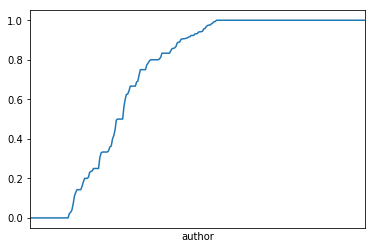

In [154]:
other_univ_campinas_miss_da_unicamp_mean.plot(xticks=[]);

From that plot, at least $40\%$ of these authors
have a really strong evidence that they're really from Unicamp.

In [155]:
some_unicamp_authors = other_univ_campinas_miss_da_unicamp_mean[
    (other_univ_campinas_miss_da_unicamp_mean >= .9999)
].index
len(some_unicamp_authors)

118

Let's apply this to the entries regarding these authors.

In [156]:
solution.loc[
    other_univ_campinas_miss_brsp_pids[
        other_univ_campinas_miss_brsp_pids.isin(
            doc_authors[
                da_author.isin(some_unicamp_authors)
            ]["pid_scielo"]
        )
    ].index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 1, 0.]

In [157]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51759,12096,669136
unesp,40148,23372,669471
unicamp,42815,17153,673023
usp,19057,64904,649030


Which are the other institution names
we're talking about in that plot?

In [158]:
da_inst[
    (doc_authors["pid_scielo"].map(solution2pids(solution)["unicamp"])
     == "unknown") &
    da_author.isin(other_univ_campinas_miss_da_unicamp_mean.index) &
    ~da_inst.isin(single_unicamp_names) &
    ~da_inst.isin(empty_inst) &
    doc_authors["pid_scielo"]
        .isin(other_univ_campinas_miss_brsp_pids) &
    ~other_univ_campinas_miss_da_sel
].unique().tolist()

['hospital maternidade leonor mendes de barros',
 'grupo interdisciplinar de estudos da determinacao e diferenciacao do sexo',
 'universidade de sao paulo',
 'universidade estadual de londrina',
 'university of amsterdam',
 'universidade federal de santa catarina',
 'novartis vaccines and diagnostics',
 'associacao de assistencia a crianca deficiente',
 'san martino hospital',
 'aborl ccf',
 'scentryphar pesquisa clinica ltda',
 'cooperacao interinstitucional de apoio a pesquisas sobre o cerebro',
 'universidade positivo',
 'capes',
 'hospital do servidor publico estadual de sao paulo',
 'instituto de medicina tropical de sao paulo',
 'faculdade de medicina de sao jose do rio preto',
 'instituto brasileiro de neurociencia e neurotecnologia',
 'universidadede sao paulo',
 'universidad del valle',
 'pontificia universidade catolica de sao paulo',
 'ufsc',
 'university of sao paulo']

Most names indeed regard to other institutions.
But CAPES isn't a university,
a *department* might exist in several universities,
and [CInAPCe](http://www.fapesp.br/1896)
(*Cooperação Interinstitucional de Apoio a Pesquisas sobre o Cérebro*)
has to do with both USP and Unicamp,
but isn't an institution.
There's an entry for [*GIEDDS*](
  https://www.fcm.unicamp.br/fcm/relacoes-publicas/saladeimprensa/grupo-interdisciplinar-de-estudos-da-determinacao-e-diferenciacao-do-sexo-comemora-30-anos
), which is unlikely to have a homonymous group elsewhere.
These few selected names in this list
are the only ones that might be seen as Unicamp.

In [159]:
other_univ_campinas_miss_res_da_sel = da_inst.isin([
    "department of periodontology and prosthodontics",
    "capes",
    "cooperacao interinstitucional de apoio a pesquisas sobre o cerebro",
]) | other_univ_campinas_miss_da_sel
other_univ_campinas_miss_res_da_unicamp_mean = doc_authors.assign(
    author=da_author,
    unicamp=da_inst.isin(single_unicamp_names) |
            (da_inst == "grupo interdisciplinar de estudos da determinacao e "
                        "diferenciacao do sexo")
)[
    da_author.isin(da_author[
        doc_authors["pid_scielo"].isin(other_univ_campinas_miss_brsp_pids) &
        other_univ_campinas_miss_res_da_sel
    ]) &
    ~other_univ_campinas_miss_res_da_sel &
    ~da_author.isin(some_unicamp_authors) &
    ~da_author.isin(empty_authors) &
    ~da_inst.isin(empty_inst)
].groupby("author")["unicamp"].mean().sort_values()
len(other_univ_campinas_miss_res_da_unicamp_mean)

146

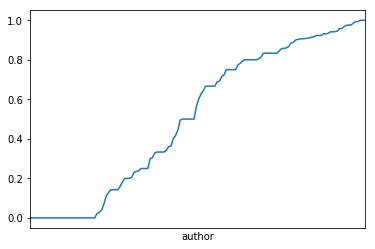

In [160]:
other_univ_campinas_miss_res_da_unicamp_mean.plot(xticks=[]);

Let's use a new threshold: $49\%$.
Which names are there besides what refers to Unicamp?

In [161]:
th49_unicamp_authors = other_univ_campinas_miss_res_da_unicamp_mean[
    other_univ_campinas_miss_res_da_unicamp_mean >= .49
].index

In [162]:
da_inst[
    (doc_authors["pid_scielo"].map(solution2pids(solution)["unicamp"])
     == "unknown") &
    da_author.isin(th49_unicamp_authors) &
    ~da_inst.isin(single_unicamp_names) &
    ~da_inst.isin(empty_inst) &
    doc_authors["pid_scielo"]
        .isin(other_univ_campinas_miss_brsp_pids) &
    ~other_univ_campinas_miss_da_sel
].unique().tolist()

['hospital maternidade leonor mendes de barros',
 'grupo interdisciplinar de estudos da determinacao e diferenciacao do sexo',
 'universidade estadual de londrina',
 'novartis vaccines and diagnostics',
 'san martino hospital',
 'aborl ccf',
 'cooperacao interinstitucional de apoio a pesquisas sobre o cerebro',
 'capes',
 'instituto brasileiro de neurociencia e neurotecnologia',
 'universidadede sao paulo',
 'university of amsterdam']

With that threshold,
it means that Unicamp appeared at least once
besides the *University of Campinas* / *Universidade de Campinas* rows.
These alternative names don't conflict with
*University of Campinas*.
An entry like PUCCAMP can "push" the meaning towards it,
but that didn't happen for this threshold.
Let's classify these as Unicamp, as well.

In [163]:
# This overwrites the previous assignment, but the value is the same
solution.loc[
    other_univ_campinas_miss_brsp_pids[
        other_univ_campinas_miss_brsp_pids.isin(
            doc_authors[
                da_author.isin(th49_unicamp_authors)
            ]["pid_scielo"]
        )
    ].index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 1., 0.]

In [164]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51781,12096,669114
unesp,40169,23372,669450
unicamp,42815,17209,672967
usp,19076,64904,649011


Which authors had entries in either *Universidad del Valle*
or *Pontifícia Universidade Católica de São Paulo*?

In [165]:
doc_authors[
    da_author.isin(da_author[
        doc_authors["pid_scielo"].isin(other_univ_campinas_miss_pids) &
        other_univ_campinas_miss_da_sel
    ]) &
    ~other_univ_campinas_miss_da_sel &
    ~da_author.isin(empty_authors) &
    ~da_inst.isin(empty_inst) &
    da_inst.isin([
        "universidad del valle",
        "pontificia universidade catolica de sao paulo",
    ])
]["doc_author"].unique().tolist()

['Octavio Ianni', 'P. A. Vasquez Monllor', 'Zeljko Loparic']

More information:

- [Octavio Ianni](
    http://www.ceoctavioianni.uerj.br/octavio.html
  ): Worked at Unicamp from 1986 to the end of his life (2004);
- [Paulo A. Vasquez Monllor](
    https://www.linkedin.com/in/paulo-vasquez-monllor-21888357/
  ): Just studied at Unicamp from 2007 to 2008
  in what looks like an incomplete undergraduation course;
- [Zeljko Loparic](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4783592Y1
  ) was already seen previously here,
  he's a professor in several universities (including Unicamp).

We now have a reason to believe that
the meaning of *University of Campinas* / *Universidade de Campinas*
is always Unicamp,
and that any other university would have some extra wording
to help on distinguishing.

In [166]:
opz_rows = dataset[
    dataset["pid"].isin(
        doc_authors[
            da_author.isin([
                "octavio ianni",
                "p a vasquez monllor",
                "zeljko loparic",
            ])
        ]["pid_scielo"]
    ) &
    dataset["institution"].isin([
        "Universidade de Campinas",
        "University of Campinas",
    ])
]
opz_rows

,collection,pid,institution,country,state,city
54347,scl,S1517-45222002000100008,Universidade de Campinas,NaN,São Paulo,NaN
86801,scl,S0103-40141996000100006,Universidade de Campinas,NaN,NaN,NaN
1239206,esp,S0212-16112009000300007,Universidade de Campinas,Brasil,SP,Campinas
1465015,psi,S1517-24302007000200002,Universidade de Campinas,NaN,NaN,NaN
1471470,psi,S1679-432X2006000200002,Universidade de Campinas,NaN,NaN,NaN
1472059,psi,S1679-432X2008000100003,Universidade de Campinas,NaN,NaN,NaN
1473328,psi,S1679-432X2007000100004,Universidade de Campinas,NaN,NaN,NaN
1473816,psi,S1679-432X2009000100006,Universidade de Campinas,NaN,NaN,NaN


Explanation:

- [S1517-45222002000100008](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1517-45222002000100008&lng=en&nrm=iso&tlng=en
  ) and [S0103-40141996000100006](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-40141996000100006&lng=en&nrm=iso&tlng=en
  ): Both from Octávio Ianni,
  the older entry has *Unicamp* clearly stated;
- [S0212-16112009000300007](
    http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-16112009000300007&lng=en&nrm=iso&tlng=en
  ): It looks like an undergraduate research;
- [S1517-24302007000200002](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1517-24302007000200002&lng=en&nrm=iso&tlng=en
  ), [S1679-432X2006000200002](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1679-432X2006000200002&lng=en&nrm=iso&tlng=en
  ), [S1679-432X2008000100003](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1679-432X2008000100003&lng=en&nrm=iso&tlng=en
  ), [S1679-432X2007000100004](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1679-432X2007000100004&lng=en&nrm=iso&tlng=en
  ) and [S1679-432X2009000100006](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1679-432X2009000100006&lng=en&nrm=iso&tlng=en
  ): all from Loparic, regarding both PUC-SP and Unicamp.

In [167]:
solution.loc[
    opz_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 1., 0.]

In [168]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51783,12096,669112
unesp,40171,23372,669448
unicamp,42815,17217,672959
usp,19078,64904,649009


How many *University of Campinas* / *Universidade de Campinas* entries
are still unknown?

In [169]:
other_univ_campinas_miss_last_pids = dataset[
    all_pre_inames.isin(other_univ_campinas_names) &
    (dataset["pid"].map(solution2pids(solution)["unicamp"]) == "unknown") &
    solution["unicamp"].isna()
]["pid"]
len(other_univ_campinas_miss_last_pids)

79

Actually, that's not the number of PIDs, but of rows.
The number of PIDs is:

In [170]:
other_univ_campinas_miss_last_pids.drop_duplicates().size

73

How many authors are still there?

In [171]:
other_univ_campinas_miss_last_da_unicamp_mean = doc_authors.assign(
    author=da_author,
    unicamp=da_inst.isin(single_unicamp_names)
)[
    da_author.isin(da_author[
        doc_authors["pid_scielo"].isin(other_univ_campinas_miss_last_pids) &
        other_univ_campinas_miss_da_sel
    ]) &
    ~other_univ_campinas_miss_da_sel &
    ~da_author.isin(empty_authors) &
    ~da_inst.isin(empty_inst)
].groupby("author")["unicamp"].mean().sort_values()
len(other_univ_campinas_miss_last_da_unicamp_mean)

38

In [172]:
other_univ_campinas_miss_last_da_unicamp_mean

author
a b soares                         0.000000
sieglinde kindl da cunha           0.000000
rosemary arrojo                    0.000000
murilo tavares daher               0.000000
marcio vidotti                     0.000000
luisa fernanda ribeiro reis        0.000000
leoncio martins rodrigues          0.000000
jose rubens costa lima             0.000000
j c n abreu                        0.000000
fabio elias verdiani tfouni        0.000000
elena brugioni                     0.000000
j raizer                           0.000000
e p silva                          0.000000
ana maria pires soubhia            0.000000
denise pires de pires              0.000000
camila ribeiro coelho              0.000000
denise m p spolidorio              0.000000
vicente amato neto                 0.022388
renato goldenberg                  0.028571
afranio mendes catani              0.111111
rogerio dias renovato              0.129032
anna hoffmann oliveira             0.142857
leandro ricardo altimari 

These will be evaluated manually.
Let's break these in $2$ parts:
one with the authors who had never published anything else,
another with the remaining authors.
The PIDs and authors without any other document
(or with empty institution elsewhere) are:

In [173]:
other_univ_campinas_miss_last_da_zeros = doc_authors[
    other_univ_campinas_miss_da_sel &
    da_author.isin(
        other_univ_campinas_miss_last_da_unicamp_mean
        [other_univ_campinas_miss_last_da_unicamp_mean == 0]
        .index
    ) &
    doc_authors["pid_scielo"].isin(other_univ_campinas_miss_last_pids)
][
    ["pid_scielo", "doc_author", "doc_author_institution"]
].drop_duplicates().set_index("pid_scielo").sort_index()
other_univ_campinas_miss_last_da_zeros

,doc_author,doc_author_institution
pid_scielo,,
S0001-63652008000400017,Ana Maria Pires Soubhia,Universidade de Campinas
S0036-46651997000600007,Denise M. P. SPOLIDÓRIO,University of Campinas
S0100-39842008000500003,Murilo Tavares Daher,Universidade de Campinas
S0102-44501998000200007,Rosemary ARROJO,Universidade de Campinas
S0102-64452001000300003,Leôncio Martins Rodrigues,Universidade de Campinas
S0103-50532008000700004,Marcio Vidotti,University of Campinas
S0104-07072007000100019,Denise Pires de Pires,Universidade de Campinas
S0104-66322001000100011,J.C.N. Abreu,Universidade de Campinas
S0104-66322009000100015,E. P. Silva,University of Campinas


Analysis:

- [S0001-63652008000400017](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S0001-63652008000400017&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0036-46651997000600007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0036-46651997000600007&lng=en&nrm=iso&tlng=en
  ): [José Francisco Höfling](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4787026U0
  ) works for Unicamp since 1971;
- [S0100-39842008000500003](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-39842008000500003&lng=en&nrm=iso&tlng=en
  ): [Murilo Tavares Daher](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4292410P8
  ) was in a specialization course at Unicamp.
  His advisor isn't an author,
  and its unknown if Unicamp is related with the contents,
  but let's keep it as an Unicamp entry;
- [S0102-44501998000200007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-44501998000200007&lng=en&nrm=iso&tlng=en
  ): [Rosemary Arrojo](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4783925E8
  ) works for Unicamp since 1984;
- [S0102-64452001000300003](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-64452001000300003&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0103-50532008000700004](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-50532008000700004&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0104-07072007000100019](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-07072007000100019&lng=en&nrm=iso&tlng=en
  ): [Denise Elvira Pires de Pires](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4787079E4
  ) ended her Ph.D. at Unicamp in 1996.
  In 2007, she was working for UFSC,
  so this entry have nothing to do with Unicamp;
- [S0104-66322001000100011](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-66322001000100011&lng=en&nrm=iso&tlng=en
  ): In 1999, when the paper was submitted, [Sérgio Bello Neves](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4708857D0
  ) still was in his Ph.D. at Unicamp;
- [S0104-66322009000100015](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-66322009000100015&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0365-05962006000400004](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0365-05962006000400004&lng=en&nrm=iso&tlng=en
  ): [José Rubens Costa Lima](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4799291D0
  ) ended his mastership at Unicamp in 2001,
  but this entry was submitted in 2004;
- [S1413-41522004000400008](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1413-41522004000400008&lng=en&nrm=iso&tlng=en
  ): [Luisa Fernanda Ribeiro Reis](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4787875D6
  ) works at USP.
  The engineering degree from Unicamp is just part of her bio;
- [S1517-55452012000100001](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1517-55452012000100001&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1518-61482008000100009](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1518-61482008000100009&lng=en&nrm=iso&tlng=en
  ): [Fabio Elias Verdiani Tfouni](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4792196P6
  ) was in his postdoc at Unicamp;
- [S1519-69842003000100008](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1519-69842003000100008&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1678-69712008000500006](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1678-69712008000500006&lng=en&nrm=iso&tlng=en
  ): [Sieglinde Kindl da Cunha](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4794537T1
  ) ended her Ph.D. at Unicamp in 1995.
  This entry have nothing to do with Unicamp;
- [S1678-91992004000100002](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1678-91992004000100002&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S2175-79682017000100065](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S2175-79682017000100065&lng=en&nrm=iso&tlng=en
  ): E-mail @iel.unicamp.br.

The USP entry is already there, we don't have to worry about it:

In [174]:
solution[solution["pid"] == "S1413-41522004000400008"].dropna()

,usp,unesp,unicamp,embrapa,pid
90397,1.0,0.0,0.0,0.0,S1413-41522004000400008


There are $4$ PIDs that have no authors from Unicamp.
They're not Unicamp because the text is part of a bio,
not because of a reference to another institution.
Let's store this new information.

In [175]:
other_univ_campinas_miss_last_zero_rows = dataset.loc[
    other_univ_campinas_miss_last_pids[
        other_univ_campinas_miss_last_pids
        .isin(other_univ_campinas_miss_last_da_zeros.index)
    ].index
].sort_values("pid")
solution.loc[
    other_univ_campinas_miss_last_zero_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = other_univ_campinas_miss_last_zero_rows.assign(
    usp=0.,
    unesp=0.,
    unicamp=1. * ~other_univ_campinas_miss_last_zero_rows["pid"].isin([
        "S0104-07072007000100019",
        "S0365-05962006000400004",
        "S1413-41522004000400008",
        "S1678-69712008000500006",
    ]),
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [176]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51789,12096,669106
unesp,40176,23372,669443
unicamp,42815,17230,672946
usp,19082,64904,649005


To finish this, let's see these PIDs:

In [177]:
other_univ_campinas_miss_last_nz_rows = dataset.loc[
    other_univ_campinas_miss_last_pids[
        ~other_univ_campinas_miss_last_pids
        .isin(other_univ_campinas_miss_last_da_zeros.index)
    ].index
].sort_values("pid")
other_univ_campinas_miss_last_nz_rows["pid"].unique()

array(['S0004-27492006000100011', 'S0020-38742018000200078',
       'S0034-71672007000600003', 'S0034-75901985000400012',
       'S0037-86821969000300005', 'S0037-86821969000600004',
       'S0100-06832002000300005', 'S0100-06832016000100310',
       'S0100-60452011000100001', 'S0100-84041998000300012',
       'S0101-20612018005022102', 'S0101-73302004000100014',
       'S0102-311X1989000400003', 'S0102-37722007000400008',
       'S0102-76382017000100022', 'S0102-76382017000300005',
       'S0102-76382018000100001', 'S0102-76382018000300001',
       'S0102-76382018000400001', 'S0102-76382018000500001',
       'S0102-86502008000600012', 'S0104-026X2006000100001',
       'S0104-12822008000300002', 'S0104-59702002000100014',
       'S0104-65001997000300003', 'S0104-66322018000200679',
       'S0104-83332008000100001', 'S0212-16112015000200011',
       'S0212-16112015000600047', 'S0327-07932012000200014',
       'S0378-18442005000900009', 'S0717-95022016000300042',
       'S0718-381X201300

Analysis:

- [S0004-27492006000100011](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0004-27492006000100011&lng=en&nrm=iso&tlng=en
  ): Submission was in 2005,
  but [Leopoldo Magacho dos Santos Silva](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4234054Y4
  ) finished his Ph.D at Unicamp in 2004.
  The same applies to [Francisco Eduardo Lopes de Lima](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4200816A8
  ), he's the only author from USP,
  but his Ph.D. at there ended in 2002.
  Unicamp and USP in this entry look like part of a mini-bio;
- [S0020-38742018000200078](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0020-38742018000200078&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0034-71672007000600003](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0034-71672007000600003&lng=en&nrm=iso&tlng=en
  ): [Mara Regina Lemes de Sordi](
  ) is written with a typo in her first name,
  but she works for Unicamp since 1996;
- [S0034-75901985000400012](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0034-75901985000400012&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0037-86821969000300005](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0037-86821969000300005&lng=en&nrm=iso&tlng=en
  ) and [S0037-86821969000600004](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0037-86821969000600004&lng=en&nrm=iso&tlng=en
  ): In 1969, [Vicente Amato Neto](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4727828U6
  ) was alive.
  It's unknown why his lattes doesn't mention Unicamp
  (perhaps because it only became a necessity later on),
  but he clearly worked to Unicamp.
  Refs.: [1](
    https://www.fcm.unicamp.br/fcm/departamento-de-clinica-medica
  ), [2](
    https://jornal.usp.br/universidade/infectologista-pioneiro-no-brasil-vicente-amato-neto-morre-aos-91-anos/
  ), [3](
    http://www.sbmt.org.br/portal/obituario-dr-vicente-amato/
  );
- [S0100-06832002000300005](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-06832002000300005&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0100-06832016000100310](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-06832016000100310&lng=en&nrm=iso&tlng=en
  ): In 2016, [Anna Hoffmann Oliveira](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4232019P4
  ) was in the middle of her postdoc at Unicamp;
- [S0100-60452011000100001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-60452011000100001&lng=en&nrm=iso&tlng=en
  ): E-mail @cle.unicamp.br;
- [S0100-84041998000300012](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-84041998000300012&lng=en&nrm=iso&tlng=en
  ): In 1997/1998, [Renato Goldenberg](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4723776E0
  ) was in the middle of his Ph.D. course at Unicamp;
- [S0101-20612018005022102](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-20612018005022102&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0101-73302004000100014](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-73302004000100014&lng=en&nrm=iso&tlng=en
  ): E-mail @unicamp.br;
- [S0102-311X1989000400003](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-311X1989000400003&lng=en&nrm=iso&tlng=en
  ): [Antonio de Azevedo Barros Filho](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4783588P3
  ) is written with a typo in his name,
  but he works for Unicamp since 1977;
- [S0102-37722007000400008](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-37722007000400008&lng=en&nrm=iso&tlng=en
  ): In 2007, [Regina Pinheiro de Oliveira e Silva](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4769025P2
  ) was in her Ph.D. course at Unicamp.
  This work had been written with her mastership's advisor,
  from UFPE,
  with a footnote stating this work is due to that mastership,
  although only 6 years after its end this work was submitted.
  Should this entry be seen as regarding to Unicamp?
  Perhaps it's a Ph.D. requirement
  (number of publications during the course),
  so it might be wrong to not count this one;
- [S0102-76382017000100022](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-76382017000100022&lng=en&nrm=iso&tlng=en
  ), [S0102-76382017000300005](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-76382017000300005&lng=en&nrm=iso&tlng=en
  ), [S0102-76382018000100001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-76382018000100001&lng=en&nrm=iso&tlng=en
  ), [S0102-76382018000300001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-76382018000300001&lng=en&nrm=iso&tlng=en
  ), [S0102-76382018000400001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-76382018000400001&lng=en&nrm=iso&tlng=en
  ) and [S0102-76382018000500001](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-76382018000500001&lng=en&nrm=iso&tlng=en
  ): Regarding Domingo M. Braile,
  *Unicamp* is always explicit,
  sometimes even *Universidade Estadual de Campinas* appears;
- [S0102-86502008000600012](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-86502008000600012&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0104-026X2006000100001](
    http://socialsciences.scielo.org/scielo.php?script=sci_arttext&pid=S0104-026X2006000100001&lng=en&nrm=iso&tlng=en
  ): In 2004, [Osmundo Santos de Araujo Pinho](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4728861A3
  ) was working at *Universidade Candido Mendes*.
  It's a translation by Rita de Souza Ávila,
  who as of today doesn't have a lattes,
  and whose [advisor's lattes](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?metodo=apresentar&id=K4266961D5
  ) tells she finished her mastership in 2003 at UnB.
  The link between the text and Unicamp is unknown,
  it probably shouldn't be regarded as belonging to Unicamp;
- [S0104-12822008000300002](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S0104-12822008000300002&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0104-59702002000100014](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-59702002000100014&lng=en&nrm=iso&tlng=en
  ): E-mail @ige.unicamp.br;
- [S0104-65001997000300003](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-65001997000300003&lng=en&nrm=iso&tlng=en
  ): E-mail @dcc.unicamp.br;
- [S0104-66322018000200679](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0104-66322018000200679&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0104-83332008000100001](
    http://socialsciences.scielo.org/scielo.php?script=sci_arttext&pid=S0104-83332008000100001&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0212-16112015000200011](
    http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-16112015000200011&lng=en&nrm=iso&tlng=en
  ): [Julicristie Machado de Oliveira](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4765048Z6
  ) works for Unicamp since 2012;
- [S0212-16112015000600047](
    http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-16112015000600047&lng=en&nrm=iso&tlng=en
  ): [Ligiana Pires Corona](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4234509T5
  ) works for Unicamp since 2014;
- [S0327-07932012000200014](
    http://www.scielo.org.ar/scielo.php?script=sci_arttext&pid=S0327-07932012000200014&lng=en&nrm=iso&tlng=en
  ): E-mail @feq.unicamp.br;
- [S0378-18442005000900009](
    http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S0378-18442005000900009&lng=en&nrm=iso&tlng=en
  ): [Silvia Maria Guerra Molina](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4785374E9
  ) finished in 1997 her Ph.D. (at Unicamp),
  it's stated in the article (received in 2009) just as a mini-bio;
- [S0717-95022016000300042](
    http://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0717-95022016000300042&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0718-381X2013000100001](
    http://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0718-381X2013000100001&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S0871-018X2013000300008](
    http://www.scielo.mec.pt/scielo.php?script=sci_arttext&pid=S0871-018X2013000300008&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1414-32832000000200011](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-32832000000200011&lng=en&nrm=iso&tlng=en
  ): In 2000, [Luiz Carlos de Oliveira Cecílio](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4799749T1
  ) was working at Unicamp;
- [S1414-32832003000100019](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-32832003000100019&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1414-32832005000100015](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1414-32832005000100015&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1414-85362009000200017](
    http://www.revenf.bvs.br/scielo.php?script=sci_arttext&pid=S1414-85362009000200017&lng=en&nrm=iso&tlng=en
  ): In 2008/2009, [Rogério Dias Renovato](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4779425Y6
  ) was in his Ph.D. course at Unicamp;
- [S1415-88092011000100009](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1415-88092011000100009&lng=en&nrm=iso&tlng=en
  ), [S1415-88092011000100010](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1415-88092011000100010&lng=en&nrm=iso&tlng=en
  ), [S1415-88092012000200003](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1415-88092012000200003&lng=en&nrm=iso&tlng=en
  ), [S1415-88092012000200005](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1415-88092012000200005&lng=en&nrm=iso&tlng=en
  ) and [S1415-88092012000200007](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1415-88092012000200007&lng=en&nrm=iso&tlng=en
  ): In 2011/2012, [José Carlos Rosa Pires de Souza](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4773427U5
  ) was working at *Universidade Católica Dom Bosco* (UCDB).
  His Ph.D. at Unicamp ended in 2001,
  it's just part of a mini-bio;
- [S1516-44462005000100007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1516-44462005000100007&lng=en&nrm=iso&tlng=en
  ): In 2004/2005, [Juliano dos Santos Souza](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4536069U6
  ) was in a specialization course at Unicamp;
- [S1516-93322006000200008](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1516-93322006000200008&lng=en&nrm=iso&tlng=en
  ) and [S1517-86922008000100003](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1517-86922008000100003&lng=en&nrm=iso&tlng=en
  ): From 2005 until 2008, [Leandro Ricardo Altimari](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4733099J6
  ) was in his Ph.D. course at Unicamp;
- [S1517-70762018000400451](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1517-70762018000400451&lng=en&nrm=iso&tlng=en
  ): E-mail @iqm.unicamp.br;
- [S1518-61482009000100007](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1518-61482009000100007&lng=en&nrm=iso&tlng=en
  ): In 2008/2009/2010, [João Batista de Menezes Bittencourt](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4121220Y1
  ) was in the middle of his Ph.D. course at Unicamp;
- [S1678-53202016000200256](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1678-53202016000200256&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1678-77572009000300010](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1678-77572009000300010&lng=en&nrm=iso&tlng=en
  ): In 2008/2009, [Safira Marques de Andrade e Silva](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4732828J7
  ) was ending her Ph.D. at Unicamp, while [Marcelo Corrêa Alves](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4718844E5
  ) was in the middle of it;
- [S1807-03022011000100003](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1807-03022011000100003&lng=en&nrm=iso&tlng=en
  ): E-mail @ime.unicamp.br;
- [S1807-17752004000100004](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1807-17752004000100004&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1807-59322016000900487](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1807-59322016000900487&lng=en&nrm=iso&tlng=en
  ): In the "Materials and Methods" section, it states
  "*All procedures were performed at*
  *the Department of Obstetrics and Gynecology,*
  *School of Medical Sciences,*
  *University of Campinas (Unicamp), [...]*";
- [S1808-86942009000600017](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1808-86942009000600017&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1809-68672013000100016](
    http://pepsic.bvsalud.org/scielo.php?script=sci_arttext&pid=S1809-68672013000100016&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit;
- [S1982-21702017000200371](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1982-21702017000200371&lng=en&nrm=iso&tlng=en
  ): Unicamp is explicit.

This entry should have not been be marked as USP:

In [178]:
solution[solution["pid"].isin([
    "S0004-27492006000100011",
])].dropna().sort_values("pid")

,usp,unesp,unicamp,embrapa,pid
108779,1.0,0.0,0.0,0.0,S0004-27492006000100011


In [179]:
solution.loc[
    solution[solution["pid"].isin([
        "S0004-27492006000100011",
    ])].dropna().index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.

Some PIDs shouldn't be marked as Unicamp.

In [180]:
nz_not_unicamp_pid_list = [
    "S0004-27492006000100011",
    "S0104-026X2006000100001",
    "S0378-18442005000900009",
    "S1415-88092011000100009",
    "S1415-88092011000100010",
    "S1415-88092012000200003",
    "S1415-88092012000200005",
    "S1415-88092012000200007",
]

In [181]:
solution.loc[
    other_univ_campinas_miss_last_nz_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = other_univ_campinas_miss_last_nz_rows.assign(
    usp=0.,
    unesp=0.,
    unicamp=1. * ~other_univ_campinas_miss_last_nz_rows["pid"].isin(nz_not_unicamp_pid_list),
    embrapa=0.,
)[["usp", "unesp", "unicamp", "embrapa"]]

In [182]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51807,12096,669088
unesp,40192,23372,669427
unicamp,42817,17278,672896
usp,19097,64903,648991


### EMBRAPA

Finding the single EMBRAPA names is quite straightforward.

In [183]:
single_embrapa_fuzzy = partial(
    regex.search,
    r"embrapa"
    r"|(empresa brasileira .* pesquisa agropecuaria){e<=4}"
    r"|(brazilian agricultural .* research corporation){e<=4}"
)
single_embrapa_names = inames[
    inames.apply(single_embrapa_fuzzy).astype(bool)
].tolist()
single_embrapa_names

['embrapa',
 'cenargen embrapa',
 'embrapa promoagro',
 'embrapa centro nacional de pesquisa de uva e vinho',
 'empresa brasileira de pesquisa agropecuaria embrapa',
 'embrapa soja',
 'embrapa agroindustria tropical',
 'embrapa rondonia',
 'embrapa iac',
 'embrapa pecuaria sudeste',
 'embrapa amazonia oriental',
 'embrapa cnpsa',
 'projeto sanidade animal embrapa ufrrj',
 'embrapa meio ambiente',
 'embrapa algodao',
 'embrapa cpap',
 'embrapa cnpdia',
 'empresa brasileira de pesquisa agropecuaria',
 'embrapa agroindustria de alimentos',
 'embrapa suinos e aves',
 'embrapa cnpab',
 'embrapa arroz e feijao',
 'embrapa semiarido',
 'embrapa recursos geneticos e biotecnologia',
 'embrapa agricultural instrumentation',
 'embrapa cenargen',
 'embrapa trigo',
 'embrapa uva e vinho',
 'embrapa hortalicas',
 'embrapa milho e sorgo',
 'embrapa cerrados',
 'empresa brasileira de pesquisas agropecuarias',
 'empresa brasileira de pesquisa agropecua',
 'embrapa solos',
 'embrapa agroflorestal de ror

In [184]:
solution.loc[
    all_pre_inames.isin(single_embrapa_names),
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 0., 1.]

In [185]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51807,12846,668338
unesp,42672,23372,666947
unicamp,45488,17278,670225
usp,21364,64903,646724


Are there names that looks like EMBRAPA?

In [186]:
almost_embrapa_acronym_rows = dataset[
    all_pre_inames.str.contains("em[bp]r?a[bp]a?") &
    solution["embrapa"].isna()
]
almost_embrapa_acronym_rows.sort_values(by="pid")

,collection,pid,institution,country,state,city
1262935,esp,S0004-05922013000100002,Empraba,Brasil,PI,Teresina
1263805,esp,S0004-05922013000200008,Empraba Roraima,Brasil,Roraima,Boa Vista
268400,scl,S0006-87052009000200007,EMPRAPA Clima Temperado,NaN,RS,Pelotas
63178,scl,S0100-06832003000600015,Emprapa/Clima Temperado,NaN,RS,Pelotas
327086,scl,S0100-879X2010000300005,Centro de Pesquisa da EMPRAPA,Brasil,CE,Sobral
182143,scl,S0102-09352007000500028,Embapa Cerrados,NaN,DF,Planaltina
771889,scl,S0103-84782018000400251,Emprapa Meio Ambiente,Brasil,SP,Jaguariúna
122162,scl,S0301-80591998000200018,EMBRAP,NaN,MG,Sete Lagoas
323363,scl,S1516-35982004000800012,EMBRABA,Brazil,NaN,NaN
440354,scl,S1517-75992009000200008,EMBAP,NaN,NaN,Curitiba


Analysis:

- [S0004-05922013000100002](
    http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-05922013000100002&lng=en&nrm=iso&tlng=en
  ): E-mail @embrapa.br;
- [S0004-05922013000200008](
    http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0004-05922013000200008&lng=en&nrm=iso&tlng=en
  ): EMBRAPA;
- [S0006-87052009000200007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0006-87052009000200007&lng=en&nrm=iso&tlng=en
  ): E-mail @cpact.embrapa.br;
- [S0100-06832003000600015](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-06832003000600015&lng=en&nrm=iso&tlng=en
  ): EMBRAPA, explicit in the body;
- [S0100-879X2010000300005](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0100-879X2010000300005&lng=en&nrm=iso&tlng=en
  ): Not as explicit as it should, but it's [Embrapa Goats & Sheep](
    https://www.embrapa.br/en/caprinos-e-ovinos/dados-cadastrais
  );
- [S0102-09352007000500028](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-09352007000500028&lng=en&nrm=iso&tlng=en
  ): EMBRAPA;
- [S0103-84782018000400251](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-84782018000400251&lng=en&nrm=iso&tlng=en
  ): E-mail @embrapa.br;
- [S0301-80591998000200018](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0301-80591998000200018&lng=en&nrm=iso&tlng=en
  ): EMBRAPA;
- [S1516-35982004000800012](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1516-35982004000800012&lng=en&nrm=iso&tlng=en
  ): It's [Embrapa Semiarid Agriculture](
    https://www.embrapa.br/en/semiarido/dados-cadastrais
  );
- [S1517-75992009000200008](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1517-75992009000200008&lng=en&nrm=iso&tlng=en
  ) and [S1517-75992012000200017](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1517-75992012000200017&lng=en&nrm=iso&tlng=en
  ): Not EMBRAPA. EMBAP stands for
  *Escola de Música e Belas Artes do Paraná*;
- [S1806-66902013000300011](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1806-66902013000300011&lng=en&nrm=iso&tlng=en
  ): E-mail @embrapa.br;

In [187]:
solution.loc[
    almost_embrapa_acronym_rows.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = almost_embrapa_acronym_rows.assign(
    usp=0.,
    unesp=0.,
    unicamp=0.,
    embrapa=1. * (almost_embrapa_acronym_rows["institution"] != "EMBAP"),
)[["usp", "unesp", "unicamp", "embrapa"]]

In [188]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51809,12855,668327
unesp,42675,23372,666944
unicamp,45491,17278,670222
usp,21366,64903,646722


Are there more names?

In [189]:
tmp_names = get_unsolved_names()
fuzzied_embrapa_names = tmp_names[
    ~tmp_names.isin(single_embrapa_names) &
    tmp_names.apply(regex.compile(
        r"(embrapa){e<=1}"
    ).search).astype(bool)
]
del tmp_names
dataset[
    all_pre_inames.isin(fuzzied_embrapa_names) &
    solution["embrapa"].isna()
]

,collection,pid,institution,country,state,city
48319,scl,S0100-06832003000300017,EMBRACAL,NaN,SP,Saltinho
152424,scl,S0101-20612007000100008,Embrarad Ltda.,Brasil,SP,São Paulo
447552,scl,S0104-66322012000300015,PAM Membranas Seletivas Ltda,Brazil,NaN,Rio de Janeiro
470313,scl,S0074-02762013000200243,Laboratório de Membranas Excitáveis e Biologia...,NaN,NaN,NaN


These don't look like EMBRAPA.

In [190]:
solution.loc[
    all_pre_inames.isin(fuzzied_embrapa_names) &
    solution["embrapa"].isna(),
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.

In [191]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51810,12855,668326
unesp,42676,23372,666943
unicamp,45492,17278,670221
usp,21366,64903,646722


How about the fake acronym EBPA?
And the substitution of B by M
(following the EMBRAPA name without the BRA in the middle)?

In [192]:
tmp_names = get_unsolved_names()
fuzzied_embrapa_names = tmp_names[
    ~tmp_names.isin(single_embrapa_names) &
    tmp_names.str.contains("(?:^| )e[bm]pa")
]
del tmp_names
pd.DataFrame(
    dataset[
        all_pre_inames.isin(fuzzied_embrapa_names) &
        solution["embrapa"].isna()
    ]
    .fillna("")
    .groupby(["institution", "country", "state", "city"])
    .size()
    .rename("count")
)

count
institution                                        country     state        city                   
Clínica Dr. Adolfo D’Empaire                                                                      1
Clínica D´Empaire                                  Venezuela                Maracaibo             1
Dr. Adolfo D’Empaire                                           Estado Zulia                       1
EMPA                                                                                              1
                                                   BR          AM           Manaus                1
                                                   Suíça                                          1
                                                                            Dübendorf             1
                                                   Switzerland                                    1
                                                                            St. Gallen            2
EMPA, Swiss Federal Laboratories for Materials ... Switzerland                                    1
EMPAER                                                                                            1
                                                               MS           Campo Grande          2
                                                                            Dourados              1
                                                               MT           Cuiabá                4
                                                                            Sinop                 1
EMPAER-MS                                                      MS           Campo Grande          1
EMPAER-MT                                                      MT           Cuiabá                2
                                                                            Sinop                 1
                                                                            Tangará da Serra      1
EMPAER/MS                                                      MS           Campo Grande          1
EMPARN                                                                                            4
                                                               PE           Petrolina             1
                                                               RN           Mossoró               1
                                                                            Natal                 9
                                                   Brazil                                         1
EMPASC                                                                      Florianópolis         1
                                                               SC           Chapecó               2
                                                                            Itajaí                1
Empaer                                                                                            1
                                                               MS           Campo Grande          1
Hospital General Dr. Adolfo D'Empaire              Venezuela                Cabimas               1
MS EMPASC                                                      SC           Itajaí                1
Policlinica Dâ€™Empaire                                        Zulia        Maracaibo             1
Policlínica D`Empaire                                          Zulia        Maracaibo             1
Policlínica D’Empaire                                          Zulia        Maracaibo             1
Servicio de oncologia  del hospital general  Dr...                                                1
Técnico da EMPAER                                              MT                                 1

This looks like trouble! Only two entries might look like EMBRAPA:
the ones with `EMPA` alone that aren't in Switzerland.
Besides the Swiss [EMPA](https://www.empa.ch/),
we have a distinction between EMBRAPA (a federal/national institution)
and state institutions like [EMPAER](http://www.empaer.mt.gov.br/)
and [EMPARN](http://www.emparn.rn.gov.br/).
EMPASC might be a reference to
[Epagri](https://www.epagri.sc.gov.br/index.php/a-epagri/quem-somos/),
or perhaps to a private company (CNPJ 06.050.958/0001-73).
The trouble is, had these words already appeared
together with EMBRAPA?
Let's finish these and check!

In [193]:
dataset[dataset["institution"] == "EMPA"].sort_values(by="pid")

,collection,pid,institution,country,state,city
601324,scl,S0044-59671993000300271,EMPA,BR,AM,Manaus
310180,scl,S0366-69132009000400007,EMPA,NaN,NaN,NaN
187588,scl,S1413-81232008000200019,EMPA,Switzerland,NaN,St. Gallen
1585867,spa,S1413-81232008000200019,EMPA,Switzerland,NaN,St. Gallen
851312,arg,S1853-35232012000100004,EMPA,Switzerland,NaN,NaN
441065,scl,S1983-41952012000300006,EMPA,Suíça,NaN,Dübendorf
439839,scl,S1983-41952012000400002,EMPA,Suíça,NaN,NaN


None are EMBRAPA:

- [S0044-59671993000300271](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0044-59671993000300271&lng=en&nrm=iso&tlng=en
  ): It's [INPA](http://portal.inpa.gov.br/), not EMPA;
- [S0366-69132009000400007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0366-69132009000400007&lng=en&nrm=iso&tlng=en
  ): It's the Swiss Federal Laboratories
  for Materials Testing and Research.

In [194]:
solution.loc[
    all_pre_inames.isin(fuzzied_embrapa_names) &
    solution["embrapa"].isna(),
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.

In [195]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51823,12855,668313
unesp,42689,23372,666930
unicamp,45506,17278,670207
usp,21377,64903,646711


Now let's look for EMBRAPA entries that match both EMBRAPA
and one of these other names/codes/acronyms.

In [196]:
dataset[
    all_pre_inames.isin(inames[
            inames.str.contains("(?:^| )e[bm]pa")
    ]) &
    solution["embrapa"].fillna(0.).apply(bool)
]

,collection,pid,institution,country,state,city
37013,scl,S1519-566X2002000300010,EMBRAPA/EMPARN,NaN,RN,Natal
68932,scl,S1519-566X2001000100009,EMBRAPA/EMPARN,NaN,RN,Natal


Both entries (
  [S1519-566X2002000300010](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1519-566X2002000300010&lng=en&nrm=iso&tlng=en
  ) and
  [S1519-566X2001000100009](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1519-566X2001000100009&lng=en&nrm=iso&tlng=en
  )
) regards to [Marcone Cesar Mendonça das Chagas](
  http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4788088Y6
),
who tells that works for both EMBRAPA and EMPARN,
however his declared work load for EMBRAPA is zero.
For the former, we've got another author from EMBRAPA,
but for the latter we'll believe that the selected author
indeed works for EMBRAPA.

That said, there's nothing to be fixed.

### Subtractive approach

We're looking for USP/UNESP/Unicamp/EMBRAPA,
but there are several other names that clearly regards to other institution,
like *Universidad Católica San Pablo* (CEU) and PUCCAMP.
USP isn't a national/federal university, but a state university,
and *City of São Paulo University* reads like UNICID, not USP.
Names like *Camilo*, *Carlos* and *Marcos* clearly aren't *Paulo*.

Let's start a "reversed approach":
the goal now is to minimize the unknowns.

#### Classifying everything with Campinas

These entries match the "single" names for Unicamp,
but they still aren't classified:

In [197]:
missed_unicamp_single = dataset[
    all_pre_inames.isin(single_unicamp_names) &
    (dataset["pid"].map(solution2pids(solution)["unicamp"]) == "unknown") &
    solution["unicamp"].isna()
]
missed_unicamp_single

,collection,pid,institution,country,state,city
40621,scl,S0102-311X1999000200009,Universidade Estadual de Campinas,NaN,Brasil,Campinas
859147,arg,S1852-42652013000200001,Universidad Estadual de Campinas,Brazil,San Pablo,Campinas
1565806,spa,S0102-311X1999000200009,Universidade Estadual de Campinas,Brazil,Brasil,Campinas


These had not been classified just because of the state.
But it's pretty clear that these regards to Unicamp.

In [198]:
solution.loc[
    missed_unicamp_single.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = [0., 0., 1., 0.]

In [199]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,51825,12855,668311
unesp,42691,23372,666928
unicamp,45506,17280,670205
usp,21379,64903,646709


Are there other institution names with the `Campina` substring
still not classified?
Yes, a lot! The ones with some negative evidence
telling it's probably not Brazil or not São Paulo:

In [200]:
dataset[
    (~wl_dataset["mb_br"] | ~wl_dataset["mb_sp"]) &
    dataset["institution"].str.contains("Campina", case=False) &
    (dataset["pid"].map(solution2pids(solution)["unicamp"]) == "unknown") &
    solution["unicamp"].isna()
]

,collection,pid,institution,country,state,city
49869,scl,S0085-56262003000200019,Instituto Agronômico de Campinas,Brazil,MG,Lavras
360715,scl,S0104-11692011000200004,Centro de Atenção Integral à Saúde de Campinas,Brazil,GO,Goiânia
603089,scl,S0102-77862015000300295,Campina Geotech,Brazil,PB,Campina Grande
766045,scl,S2358-04292018000100300,Faculdade Unida de Campinas,Brazil,Goiás,Goiânia
766070,scl,S2358-04292018000100200,United College of Campinas,Brazil,GO,Goiânia
1514491,rve,S0104-11692011000200004,Centro de Atenção Integral à Saúde de Campinas,Brazil,GO,Goiânia
1525613,rve,S1517-38522008000200002,Programa Saúde da Família de Campina da Lagoa,NaN,PR,Campina da Lagoa


None belongs to Unicamp.
The only name that could be trouble is the health center,
which might exist elsewhere,
but we're seeing all rows where that name appears.

In [201]:
(all_pre_inames == "centro de atencao integral a saude de campinas").sum()

2

Some names we know that aren't Unicamp
(nor USP/UNESP/EMBRAPA):

- [IAC](http://www.iac.sp.gov.br/), *Instituto Agronômico de Campinas*;
- `Faculdade Unida de Campinas` (FacUNICAMPS)
  is at *Goiás* (another Brazilian state),
  it's not UNICAMP.
  The  `United College` entry belongs to it,
  as well;
- Stuff related to the *Campina da Lagoa* city, PR;
- Stuff related to the *Campina Grande* city, GO.
- PUCCAMP, *Pontifícia Universidade Católica*;
- `Faculdade Politécnica de Campinas` (POLICAMP)
  is at Campinas-SP,
  but it's not UNICAMP;
- UNIMEP, *Universidade Metodista de Piracicaba*,;
- State/city secretariats/bureaus in Campinas;
- We're looking for a state institution,
  so the words related to a city institution can also be removed.

Let's create a filter to remove some of these.

In [202]:
tmp_names = get_unsolved_names()
more_campinas_not_unicamp_names = tmp_names[
    ~tmp_names.isin(single_unicamp_names) &
    tmp_names.apply(regex.compile(
        r"puccamp|unimep"
        r"|((secretaria|prefeitura|municipal) .* campinas){e<=2}"
        r"|(campinas .* (secretariat|bureau)){e<=2}"
        r"|(metodista){e<=2}"
        r"|(campina (geotech|da lagoa)){e<=1}"
        r"|(uni(ted|da).*campina){e<=1}"
        r"|(instituto agronomico de campinas){e<=2}"
        r"|(policamp){e<=1}"
        r"|(politecnica.*campinas){e<=2}"
    ).search).astype(bool)
]
del tmp_names
more_campinas_not_unicamp_names.tolist()

['instituto agronomico de campinas',
 'puccamp',
 'unimep',
 'universidade metodista de sao paulo',
 'maternidade de campinas',
 'universidade metodista de piracicaba',
 'nstituto agronomico de campinas',
 'secretaria municipal de saude de campinas',
 'prefeitura municipal de campinas',
 'secretaria municipal de educacao de campinas sp',
 'universidade metodista de piracicaba e unicastelo',
 'instituto metodista bennett',
 'instituto metodista benett',
 'methodist hospital',
 'universidade metodista',
 'assistencia domiciliar unimed campinas',
 'universidade metodista de santos',
 'unicentro metodista izabela hendrix',
 'rede metodista ipa',
 'secretaria de educacao do municipio de campinas',
 'rede metodista de educacao',
 'methodist university of piracicaba',
 'piracicaba methodist university',
 'intituto agronomico de campinas',
 'centro universitario metodista porto alegre',
 'centro universitario metodista ipa',
 'universidade metodista de piracicabapaulo',
 'prefeitura de campina

This huge list have only one name that's worth detailing:

In [203]:
dataset[all_pre_inames == "campinas y unimep"]

,collection,pid,institution,country,state,city
1236763,esp,S0212-16112006000100007,Campinas y UNIMEP,Brasil,SP,Piracicaba


[That entry](
  http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-16112006000100007&lng=en&nrm=iso&tlng=en
) doesn't belong to Unicamp.
[Vânia Aparecida Leandro Merhi](
  http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4707247A1
) studied at Unicamp, but this entry regards to PUCCAMP and UNIMEP.

Then let's add to the solution all entries belonging to these names.

In [204]:
solution.loc[
    all_pre_inames.isin(more_campinas_not_unicamp_names) &
    solution["unicamp"].isna(),
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.

In [205]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,52492,12855,667644
unesp,43307,23372,666312
unicamp,46075,17280,669636
usp,21881,64903,646207


The last assignment still hadn't marked as "false" the
entries with *Centro de Atenção Integral à Saúde de Campinas*
in Goiânia.
Actually, we can get rid from all "centers" that looks like
campinas but actually aren't in São Paulo, Brazil.

In [206]:
campinas_centers_notbr_notsp = dataset[
    (~wl_dataset["mb_br"] | ~wl_dataset["mb_sp"]) &
    all_pre_inames.apply(regex.compile(
        r"(centro.*campinas){e<=2}"
    ).search).astype(bool) &
    (dataset["pid"].map(solution2pids(solution)["unicamp"]) == "unknown") &
    solution["unicamp"].isna()
]
campinas_centers_notbr_notsp

,collection,pid,institution,country,state,city
303675,scl,S0102-86502010000300013,Centro de Investigación Proyecto CAMINA A.C.,México,NaN,NaN
360715,scl,S0104-11692011000200004,Centro de Atenção Integral à Saúde de Campinas,Brazil,GO,Goiânia
753785,scl,S1415-790X2017000400636,Centro Universitário Unifaminas,Brasil,MG,Muriaé
832058,arg,S1852-38622008000300005,Centro Nefrológico Zárate-Campana,Argentina,Buenos Aires,NaN
846820,arg,S1852-38622006000300004,Centro Nefrológico Zárate-Campana,Argentina,Bs. As.,NaN
896421,bol,S2077-21612014000100006,Centro de Salud Familiar Campanario Yungay,Chile,NaN,NaN
934675,chl,S0301-732X2010000200012,Centro de Investigación Proyecto CAMINA A.C,Mexico,NaN,México DF
943893,chl,S0301-732X2011000300004,Centro de Investigación Proyecto CAMINA A.C,Mexico,NaN,Ciudad de México
1062169,cub,S1561-31942017000200013,Centro de Información y Gestión Tecnológica. P...,Cuba,NaN,Pinar del Río
1254160,esp,S1139-76322011000400016,Centro de Salud La Campiña,España,NaN,Marchamalo


In [207]:
solution.loc[
    campinas_centers_notbr_notsp.index,
    ["usp", "unesp", "unicamp", "embrapa"]
] = 0.

In [208]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,52494,12855,667642
unesp,43309,23372,666310
unicamp,46077,17280,669634
usp,21883,64903,646205


It wasn't exhaustive: there are names with Campinas.

### Common institution names

In [209]:
def get_unknowns_table(count):
    unknowns = (solution2pids(solution) == "unknown").any(axis=1)
    return pd.DataFrame(
        dataset[
            dataset["pid"].isin(unknowns[unknowns].index) &
            solution.isna().any(axis=1)
        ].assign(inst=all_pre_inames)
        .groupby(["inst", "country", "state", "city"])
        .size()
        .sort_values()
        .rename("count")
        .sort_values(ascending=False)
    )[:count]

In [210]:
unk_table1 = get_unknowns_table(50)
unk_table1

,,,,count
inst,country,state,city,
universidade federal do rio grande do sul,Brazil,Rio Grande do Sul,Porto Alegre,9972
universidade federal de minas gerais,Brazil,Minas Gerais,Belo Horizonte,9971
universidade federal do rio de janeiro,Brazil,Rio de Janeiro,Rio de Janeiro,8729
universidade federal de vicosa,Brazil,Minas Gerais,Viçosa,6880
universidade federal do parana,Brazil,Paraná,Curitiba,6653
universidade federal de santa catarina,Brazil,Santa Catarina,Florianópolis,5749
universidade federal de sao paulo,Brazil,São Paulo,São Paulo,5126
universidade federal de lavras,Brazil,Minas Gerais,Lavras,4872
universidade federal de santa maria,Brazil,Rio Grande do Sul,Santa Maria,4862


None of these are USP/UNESP/Unicamp/EMBRAPA,
and for these names,
it doesn't matter the country/state/city.

In [211]:
unk_table1_sel = all_pre_inames.isin(unk_table1.reset_index()["inst"])
solution[unk_table1_sel] = solution[unk_table1_sel].fillna(0.)

In [212]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,175079,12855,545057
unesp,167168,23372,542451
unicamp,170878,17280,544833
usp,141182,64903,526906


In [213]:
unk_table2 = get_unknowns_table(50)
unk_table2

,,,,count
inst,country,state,city,
universidade federal rural do semi arido,Brazil,Rio Grande do Norte,Mossoró,745
universidade federal dos vales do jequitinhonha e mucuri,Brazil,Minas Gerais,Diamantina,709
universidade estadual de ponta grossa,Brazil,Paraná,Ponta Grossa,681
pontificia universidade catolica de sao paulo,Brazil,São Paulo,São Paulo,680
universidade estadual de feira de santana,Brazil,Bahia,Feira de Santana,662
universidade estadual da paraiba,Brazil,Paraíba,Campina Grande,645
universidade do vale do rio dos sinos,Brazil,Rio Grande do Sul,São Leopoldo,623
universidade de pernambuco,Brazil,Pernambuco,Recife,589
universidade de passo fundo,Brazil,Rio Grande do Sul,Passo Fundo,565


Again, these are not USP/UNESP/Unicamp/EMBRAPA.
These are the names of autonomous institutions,
it's unlikely that any other university
would have a division with the same name
and that such information
would get written instead of the actual university name:

- [*Instituto de Botânica*](
    http://www3.ambiente.sp.gov.br/institutodebotanica/
  )
- [*Instituto Dante Pazzanese de Cardiologia*](
    http://www.idpc.org.br/historia/
  ) (IDPC)
- [*Irmandade da Santa Casa de Misericórdia de São Paulo*](
    https://www.santacasasp.org.br/portal/site/quemsomos/historico
  )
- [*Faculdade de Medicina de São José do Rio Preto*](
    http://www.famerp.br/
  ) (FAMERP)

From these, IDPC has a lot to do with USP, and may be said USP
if we were talking about education.
[USP-IDPC](
  http://sites.usp.br/usp-idpc/apresentacao/
) is an association for *stricto sensu* graduation courses,
IDPC isn't an USP division.

In [214]:
unk_table2_sel = all_pre_inames.isin(unk_table2.reset_index()["inst"])
solution[unk_table2_sel] = solution[unk_table2_sel].fillna(0.)

In [215]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,222731,12855,497405
unesp,214817,23372,494802
unicamp,218777,17280,496934
usp,187416,64903,480672


There's no USP-IDPC entry, just a few IDPC names.

In [216]:
idpc_names = inames[inames.str.contains("idpc")]
idpc_sel = all_pre_inames.isin(idpc_names)
all_pre_inames[idpc_sel].value_counts()

idpc                                    7
unidade coronariana do idpc brasil      1
idpc sp                                 1
divisao de enfermagem do idpc brasil    1
Name: institution, dtype: int64

In [217]:
solution[idpc_sel] = solution[idpc_sel].fillna(0.)

In [218]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,222736,12855,497400
unesp,214822,23372,494797
unicamp,218782,17280,496929
usp,187418,64903,480670


### Names that appears at least 10x

At first,
let's work only with names that appeared at least $10$ times
in the data.
Most of the data is there,
and the entries matching this subset of names
should somehow be fully classified.

In [219]:
all_pre_inames_counts = all_pre_inames.value_counts()
inames10 = pd.Series(all_pre_inames_counts[all_pre_inames_counts >= 10].index)

In [220]:
print(f"There are {len(inames10)} "
      f"out of {len(inames)} with 10+ entries, "
      f"and {inames10.isin(get_unsolved_names()).sum()} of these "
      f"are still unsolved.")

There are 8493 out of 148894 with 10+ entries, and 8267 of these are still unsolved.


We are seeing way too many *federal* universities
in the top $100$ unknown entries we've just classified.
The ones in Campinas had already been removed,
but there might be stuff like *UNIFESP and USP*
that might be classified as USP,
that is, the `institution` field
might have more than one institution filled in.
What are all these names?

In [221]:
tmp_names = get_unsolved_names()
unk_federal_names10 = tmp_names[
    tmp_names.str.contains("federal") &
    tmp_names.isin(inames10)
]
del tmp_names
sorted(unk_federal_names10)

['bahia federal university',
 'caixa economica federal',
 'ceara federal university',
 'centro de investigaciones y estudios superiores en antropologia social distrito federal',
 'centro federal de educacao tecnologica',
 'centro federal de educacao tecnologica celso suckow da fonseca',
 'centro federal de educacao tecnologica da bahia',
 'centro federal de educacao tecnologica de cuiaba',
 'centro federal de educacao tecnologica de minas gerais',
 'centro federal de educacao tecnologica de quimica de nilopolis',
 'centro federal de educacao tecnologica do espirito santo',
 'centro federal de educacao tecnologica do parana',
 'centro federal de educacao tecnologica do rio de janeiro',
 'centro universitario do distrito federal',
 'centro universitario federal',
 'centro universitario planalto do distrito federal',
 'comision federal de electricidad',
 'conselho federal de fonoaudiologia',
 'conselho federal de medicina',
 'conselho federal de psicologia',
 'ecole polytechnique federale

The only name that might look ambiguous
is the `federal university`.
As we've seen an Unicamp entry
with the misleading *federal* word,
let's check the entries regarding this vague institution names:

In [222]:
dataset[
    (all_pre_inames == "federal university") &
    solution.drop(columns=["pid"]).isna().any(axis=1) &
    wl_dataset["mb_br"] &
    wl_dataset["mb_sp"]
].assign(
    usp=dataset["pid"].map(solution2pids(solution)["usp"]),
)

,collection,pid,institution,country,state,city,usp
48520,scl,S0102-86502002000500002,Federal University,NaN,NaN,NaN,unknown
84046,scl,S1516-44462005000100007,Federal University,NaN,NaN,NaN,unknown
129538,scl,S0036-46651992000500007,Federal University,Brazil,NaN,NaN,unknown
968513,chl,S0718-381X2014000200022,Federal University,Brazil,São Paulo,NaN,true
1330092,mex,S0185-16672012000400003,Federal University,Brazil,NaN,Rio de Janeiro,unknown


Analysis:

- [S0102-86502002000500002](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0102-86502002000500002&lng=en&nrm=iso&tlng=en
  ): Has a reference to *Escola Paulista de Medicina* (EPM-UNIFESP);
- [S1516-44462005000100007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S1516-44462005000100007&lng=en&nrm=iso&tlng=en
  ): All from RS, not SP;
- [S0036-46651992000500007](
    http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0036-46651992000500007&lng=en&nrm=iso&tlng=en
  ): UFMG is explicit, though some entries might look ambiguous.
  From the context, I'm assuming they're all from the same university;
- [S0718-381X2014000200022](
    http://www.scielo.cl/scielo.php?script=sci_arttext&pid=S0718-381X2014000200022&lng=en&nrm=iso&tlng=en
  ): Several authors are from USP,
  but [Carla Máximo Prado](
    http://buscatextual.cnpq.br/buscatextual/visualizacv.do?id=K4778816Z9
  ), who works for UNIFESP;
- [S0185-16672012000400003](
    http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S0185-16672012000400003&lng=en&nrm=iso&tlng=en
  ): UFRJ.

So it should be okay to say none of these federal names
regard to USP/UNESP/Unicamp/EMBRAPA.

In [223]:
unk_federal_names10_sel = all_pre_inames.isin(unk_federal_names10)
solution[unk_federal_names10_sel] = solution[unk_federal_names10_sel].fillna(0.)

In [224]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,233159,12855,486977
unesp,225401,23372,484218
unicamp,229597,17280,486114
usp,197586,64903,470502


We should not worry
with common names that can be neither Brazil nor SP.

Problem is, EMBRAPA isn't at São Paulo,
and the institution might be in another country.
Which of these more common names might have anything to do with EMBRAPA?

In [225]:
maybe_embrapa_inames10 = inames10[inames10.apply(regex.compile(
    r"(labex){e<=1}"
    r"|(embrapa){e<=2}"
    r"|(empresa brasileira){e<=2}"
    r"|(brazilian agricultural research){e<=4}"
    r"|(agronomic engineer){e<=2}"
).search).astype(bool) & inames10.isin(get_unsolved_names())].tolist()
maybe_embrapa_inames10

['instituto politecnico de braganca',
 'hospital de braga',
 'cebrap',
 'empresa brasileira de aeronautica',
 'embraer',
 'fundacao municipal de ensino superior de braganca paulista',
 'empresa brasileira de servicos hospitalares']

These aren't EMBRAPA. We can classify these.

In [226]:
maybe_embrapa_inames10_sel = all_pre_inames.isin(maybe_embrapa_inames10)
solution[maybe_embrapa_inames10_sel] = solution[maybe_embrapa_inames10_sel].fillna(0.)

In [227]:
pids2stats(solution2pids(solution))

target,false,true,unknown
institute,,,
embrapa,233313,12855,486823
unesp,225552,23372,484067
unicamp,229746,17280,485965
usp,197711,64903,470377


## Part 5: Saving the results

Let's save the four PID lists in a single XLSX file,
as well as the full table of results for each PID.

In [228]:
import openpyxl

In [229]:
pids = solution2pids(solution).sort_index()

In [230]:
wb = openpyxl.Workbook(write_only=True)
for acronym in ["usp", "unesp", "unicamp", "embrapa"]:
    ws = wb.create_sheet(title=acronym.upper())
    ws.column_dimensions["A"].width = 26
    for pid in pids[pids[acronym] == "true"].index:
        ws.append([pid])

ws = wb.create_sheet(title="Full")
ws.column_dimensions["A"].width = 26
ws.append(["PID"] + [k.upper() for k in pids.columns])
for row in pids.reset_index().values:
    ws.append(row.tolist())

wb.save("pids_network_2018-12-10_usp_unesp_unicamp_embrapa.xlsx")